<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0"> </div>
    <div style="float: left; margin-left: 10px;"> 
        <h1>Time Series Analysis</h1>
        <h1>Machine Learning</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
        @bgoncalves, @data4sci</p></div>
</div>

In [1]:
import warnings
warnings.filterwarnings("ignore")

from collections import Counter
from pprint import pprint

import pandas as pd
from pandas.plotting import autocorrelation_plot

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

import numpy as np

import matplotlib
import matplotlib.pyplot as plt 

import watermark

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 20.5.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

Git hash: cb359d5f1b6a097e176b437218ac5ab9b4f6dec9

numpy      : 1.19.2
watermark  : 2.1.0
statsmodels: 0.12.0
pandas     : 1.1.3
json       : 2.0.9
matplotlib : 3.3.2



Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')

## Load the dataset
GDP data from the Federal Reserve Bank [website](https://fred.stlouisfed.org/series/GDP)

In [4]:
series = pd.read_csv('data/GDP.csv', header=0, parse_dates=[0], index_col=0)

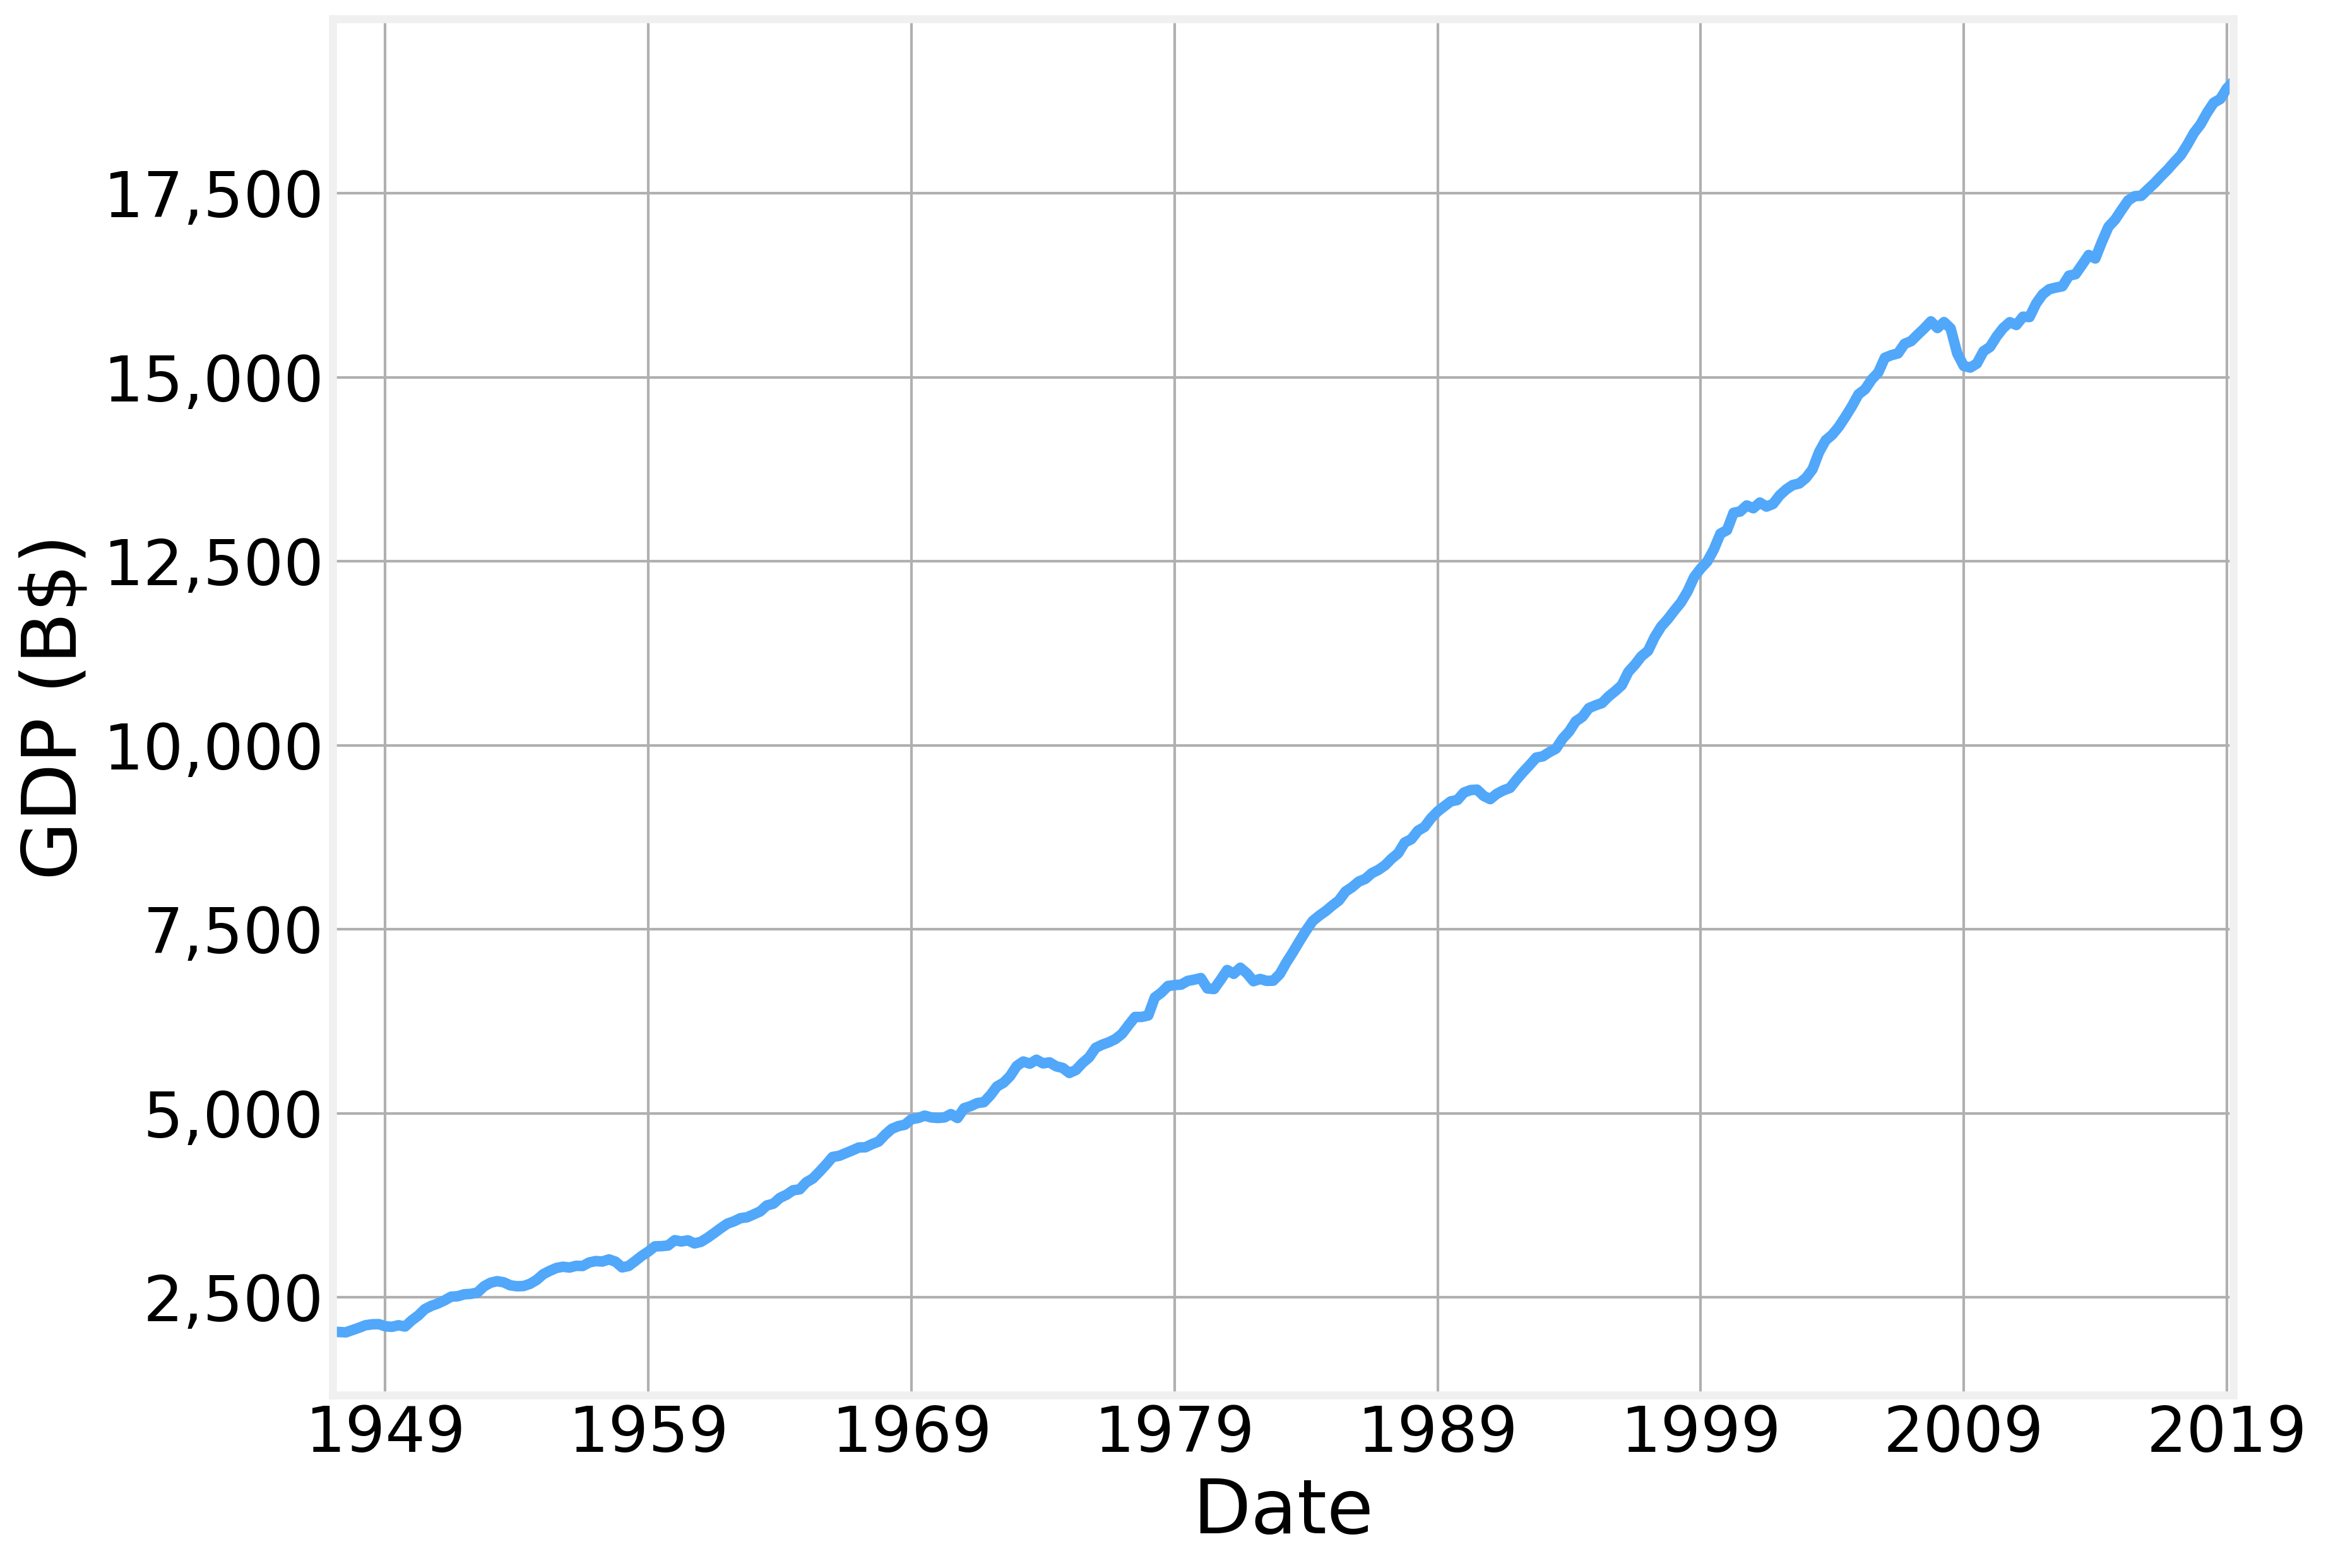

In [5]:
ax = series.plot(legend=False)
ax.set_xlabel('Date')
ax.set_ylabel('GDP (B$)')
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')));

The values at time $t+1$ are very strongly correlated with the points at $t$

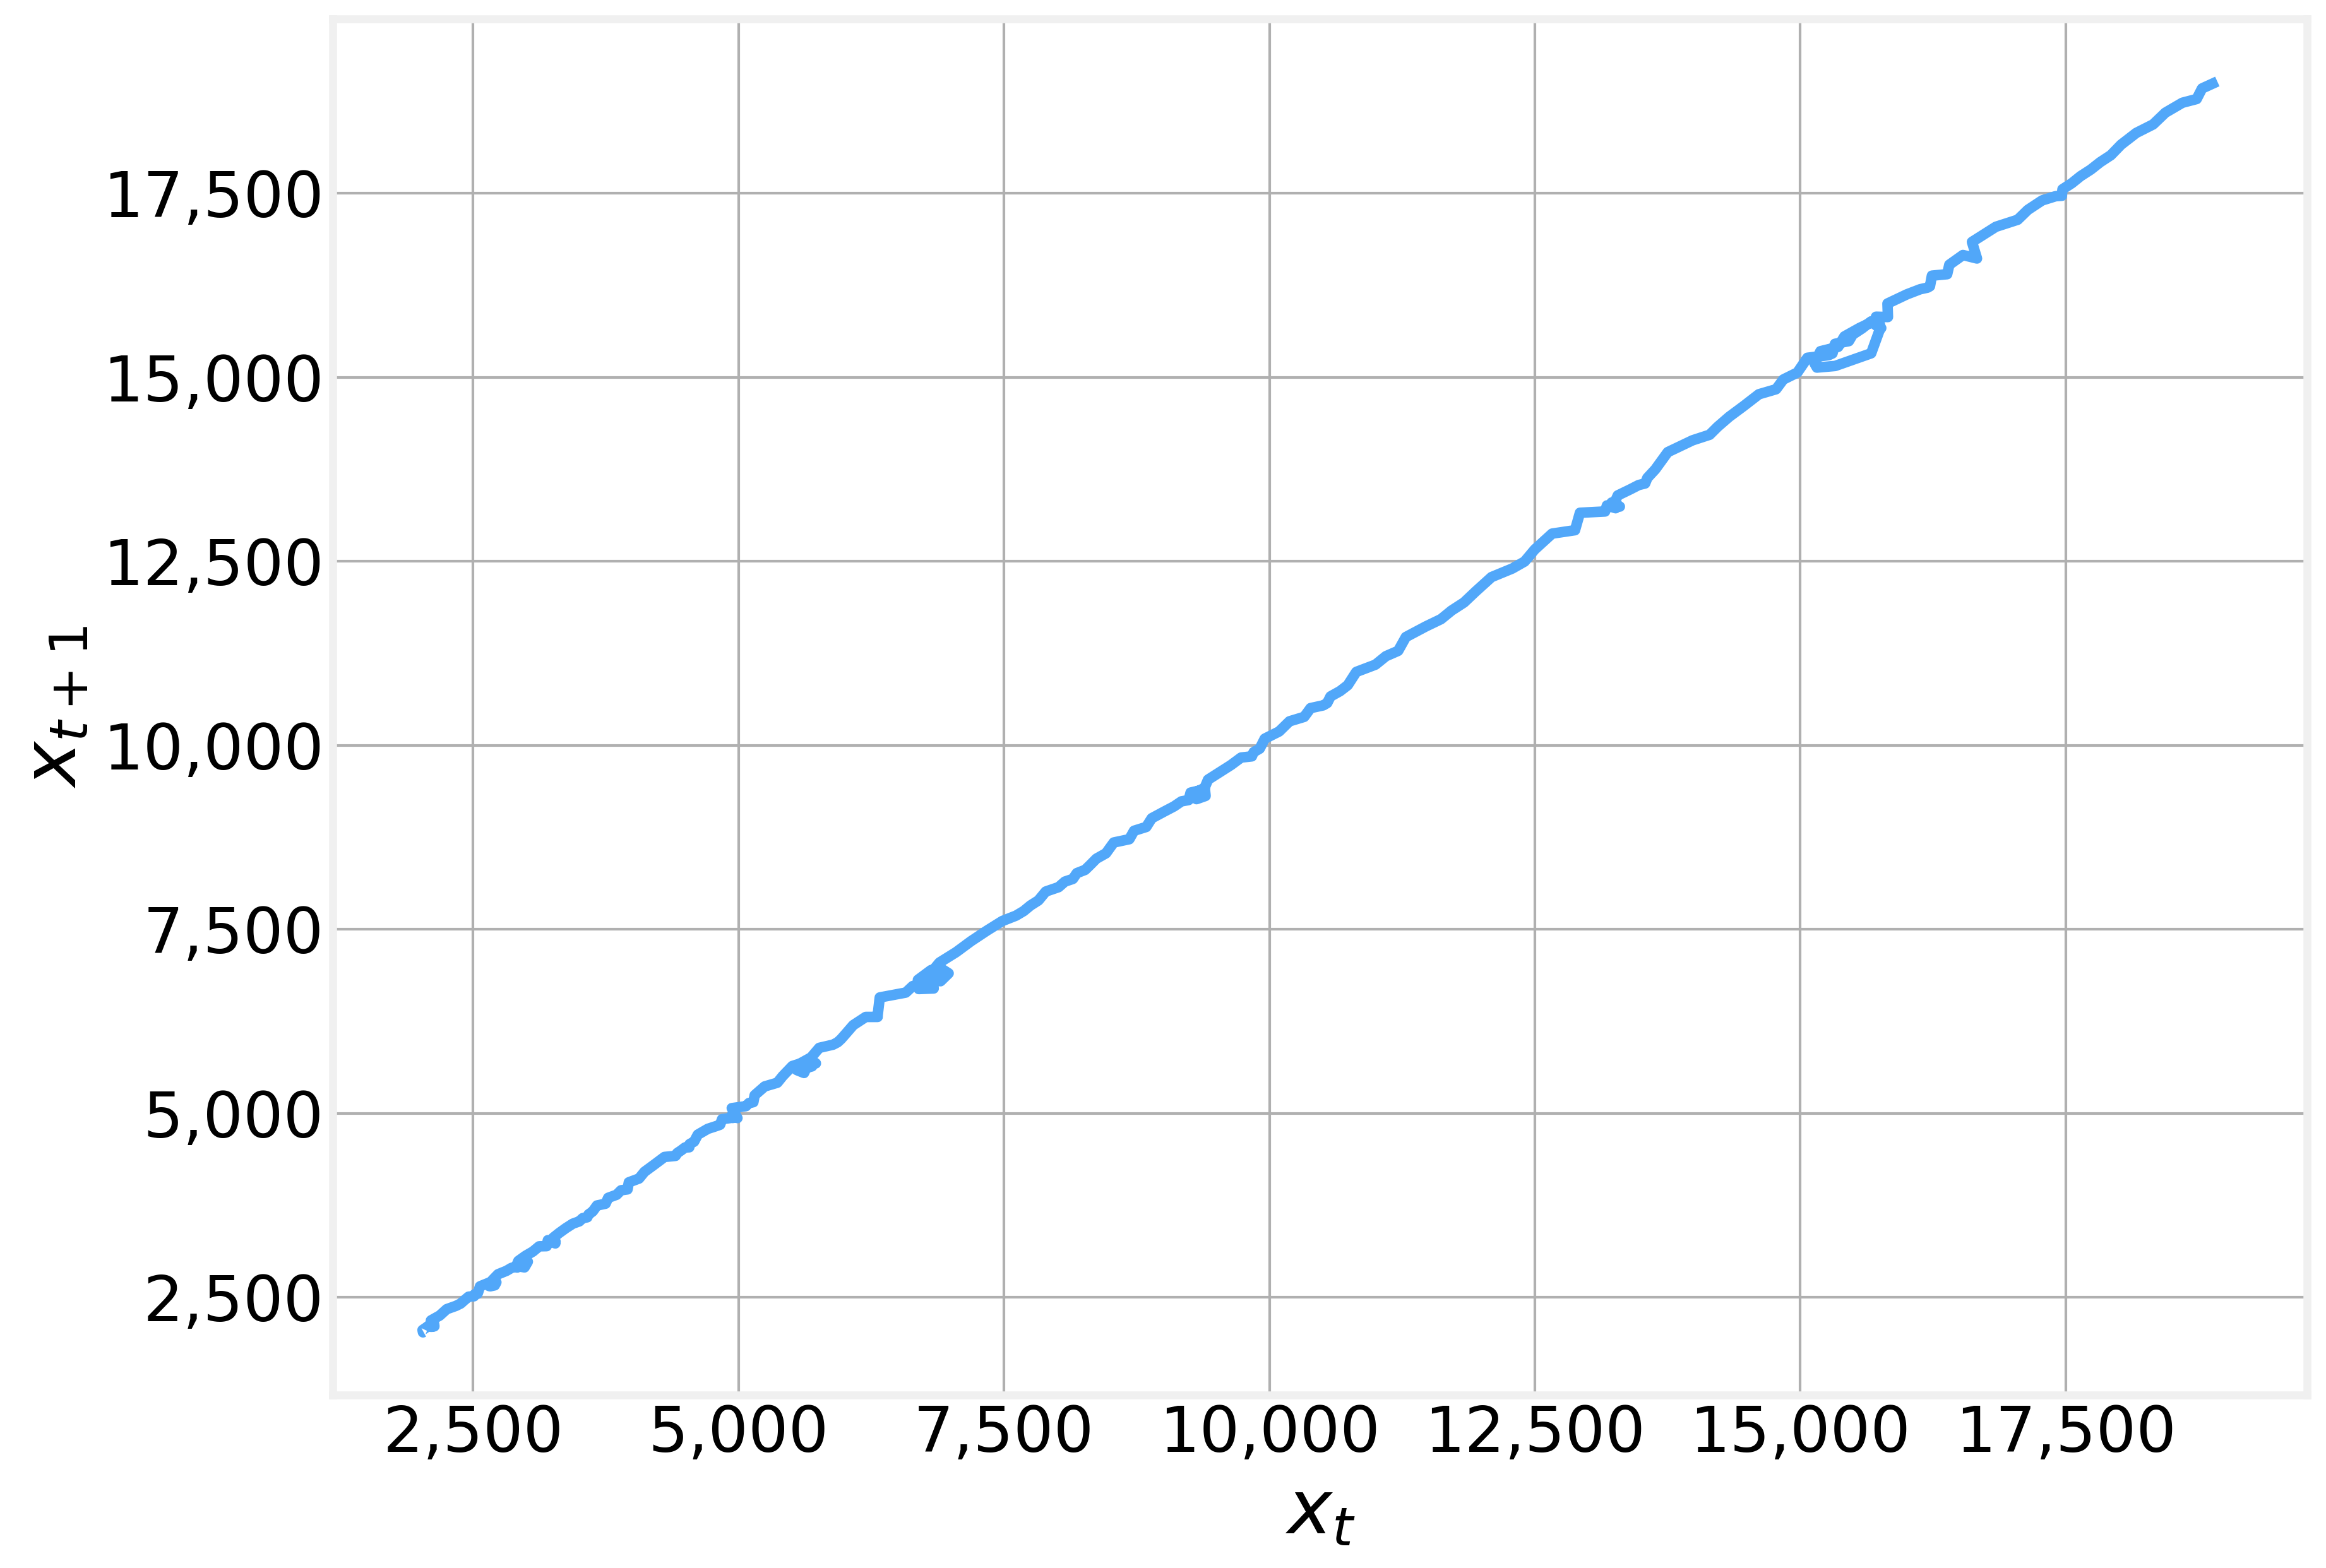

In [6]:
fig, ax = plt.subplots(1)
ax.plot(series.iloc[:-1], series.iloc[1:])
ax.set_xlabel(r'$x_{t}$')
ax.set_ylabel(r'$x_{t+1}$')
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')));
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')));

What happens if we try to naively fit $x_{t+1}=f\left(x_t\right)$? Perform a linear regression and plot the original data and the regressed data together

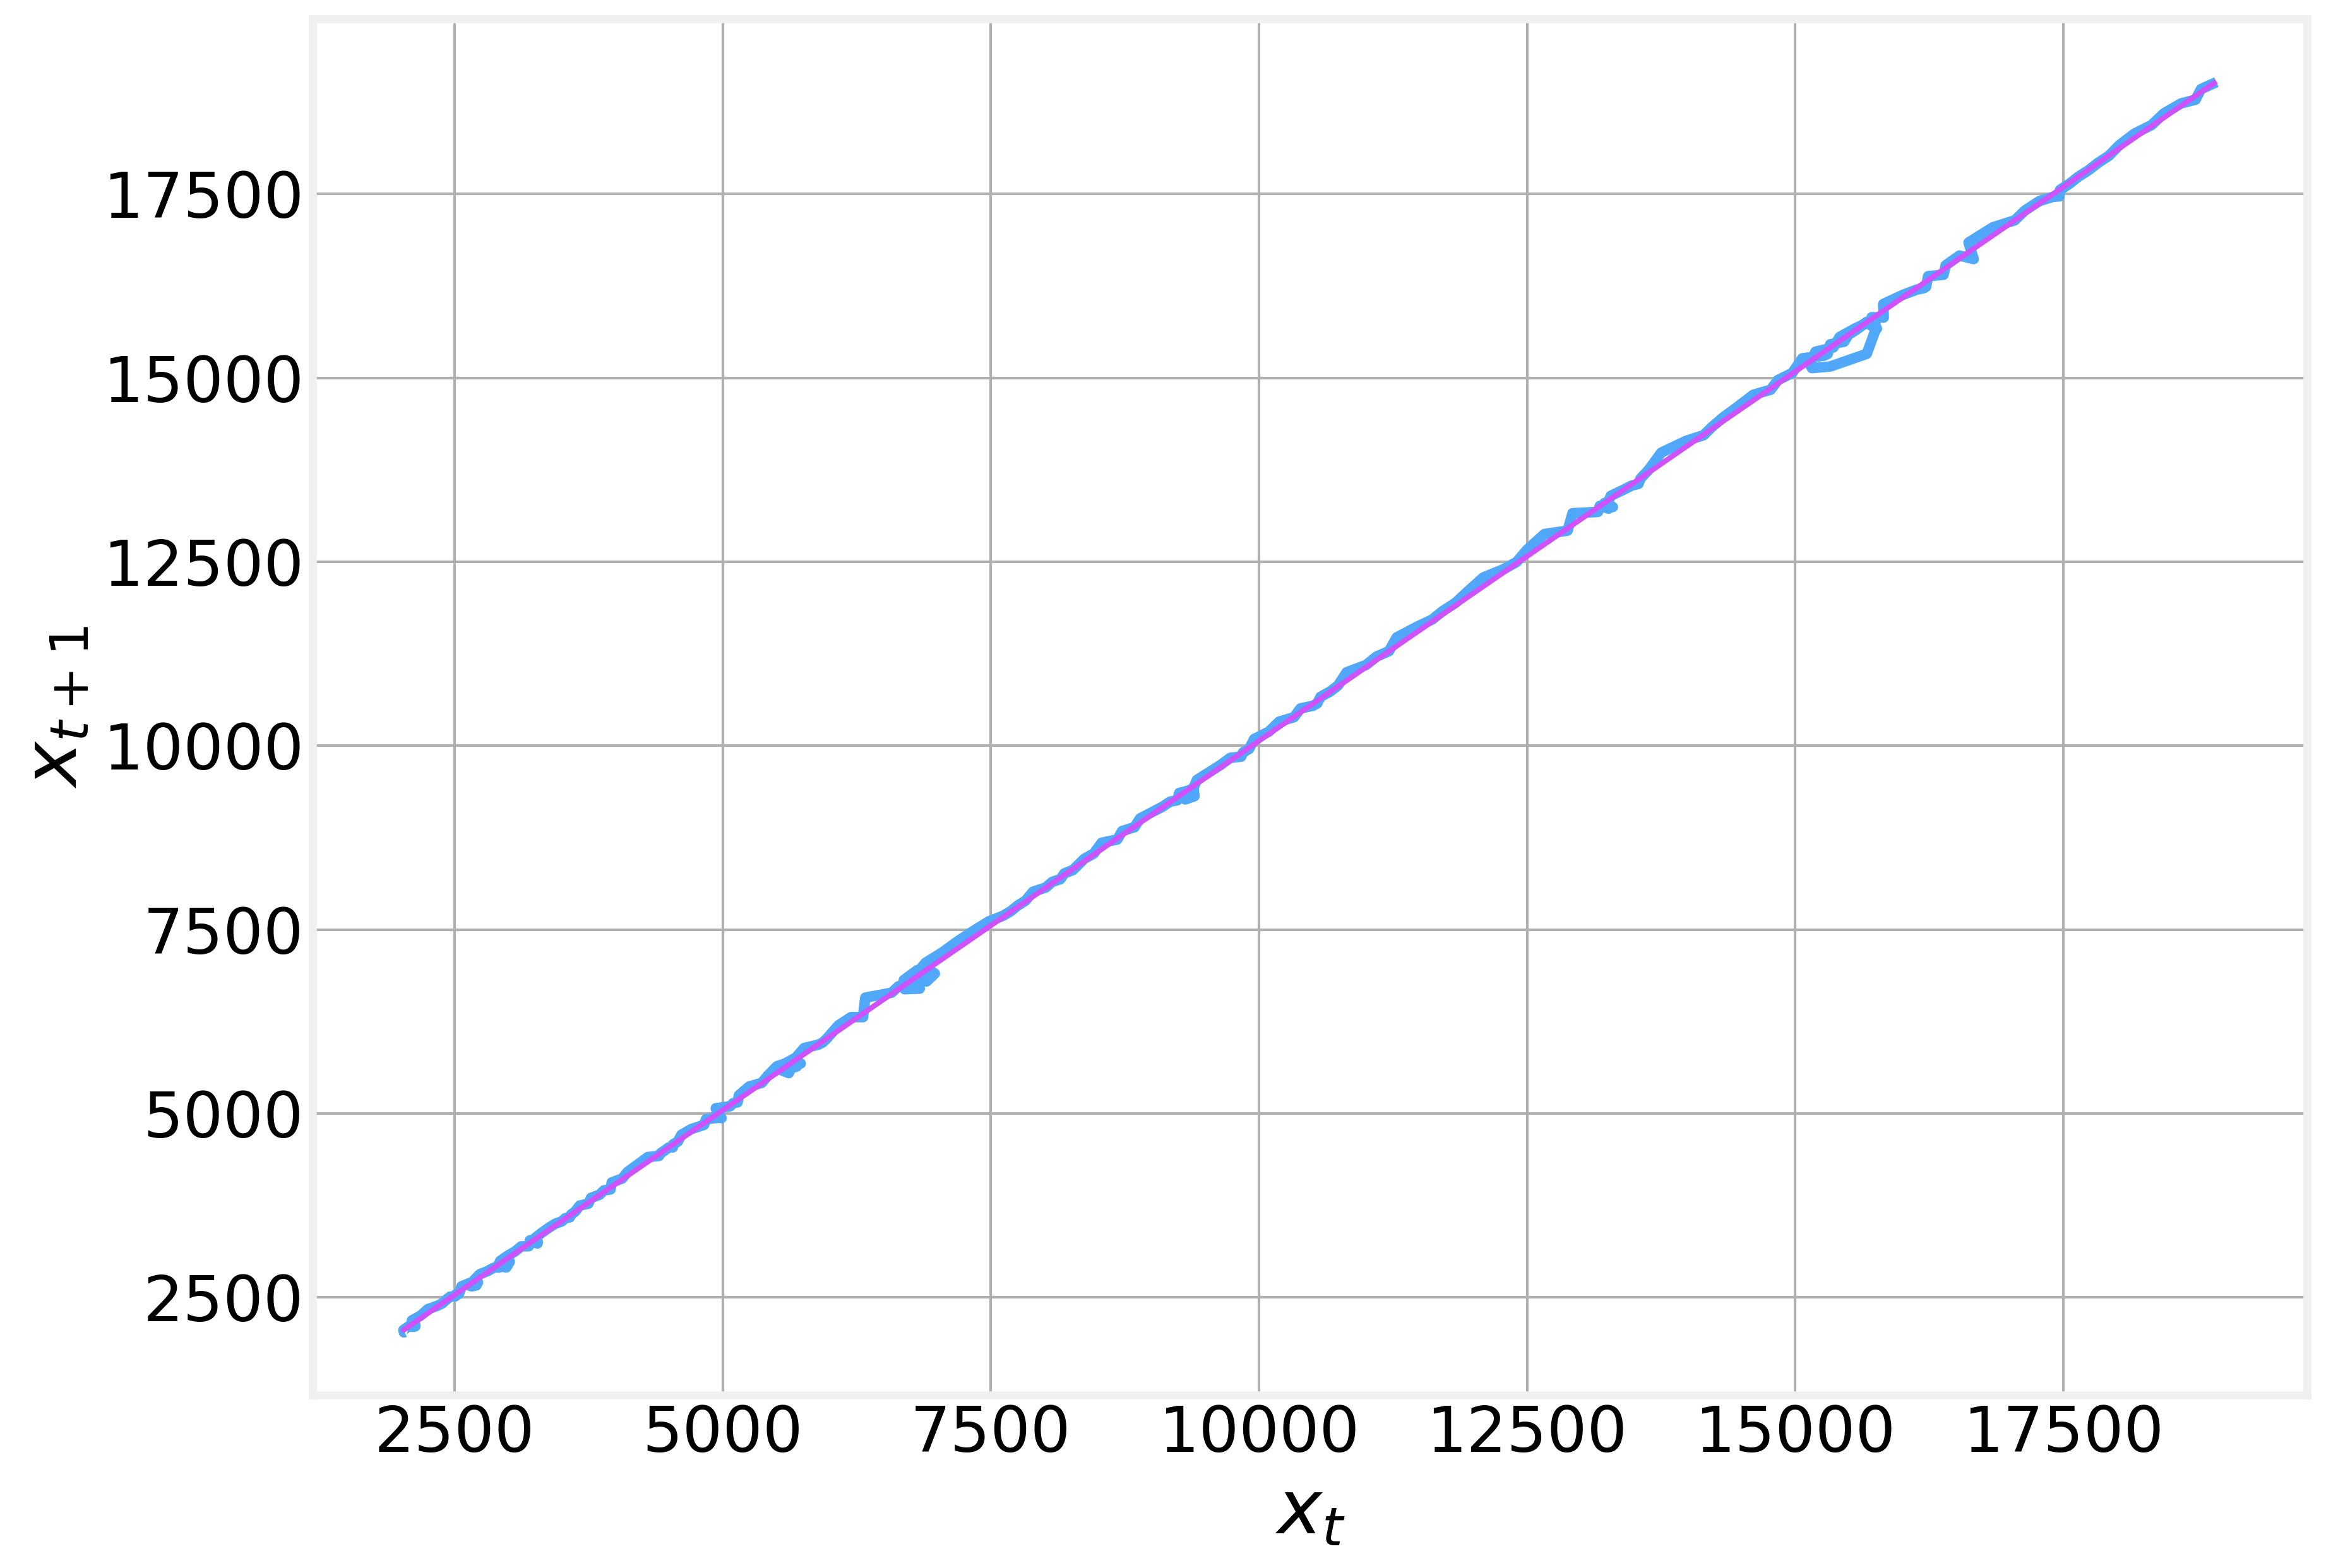

In [7]:
values = series.dropna().values
X = values[:-1].reshape(-1, 1)
y = values[1:].reshape(-1, 1)

lm = LinearRegression()
lm.fit(X, y)

y_pred = lm.predict(X)

fig, ax = plt.subplots(1)
ax.plot(series.iloc[:-1], series.iloc[1:])
ax.plot(series.iloc[:-1], y_pred, lw=2)
ax.set_xlabel(r'$x_{t}$')
ax.set_ylabel(r'$x_{t+1}$');

## Data Leakeage

So far so good. Let's go ahead and compare the original series with this fit

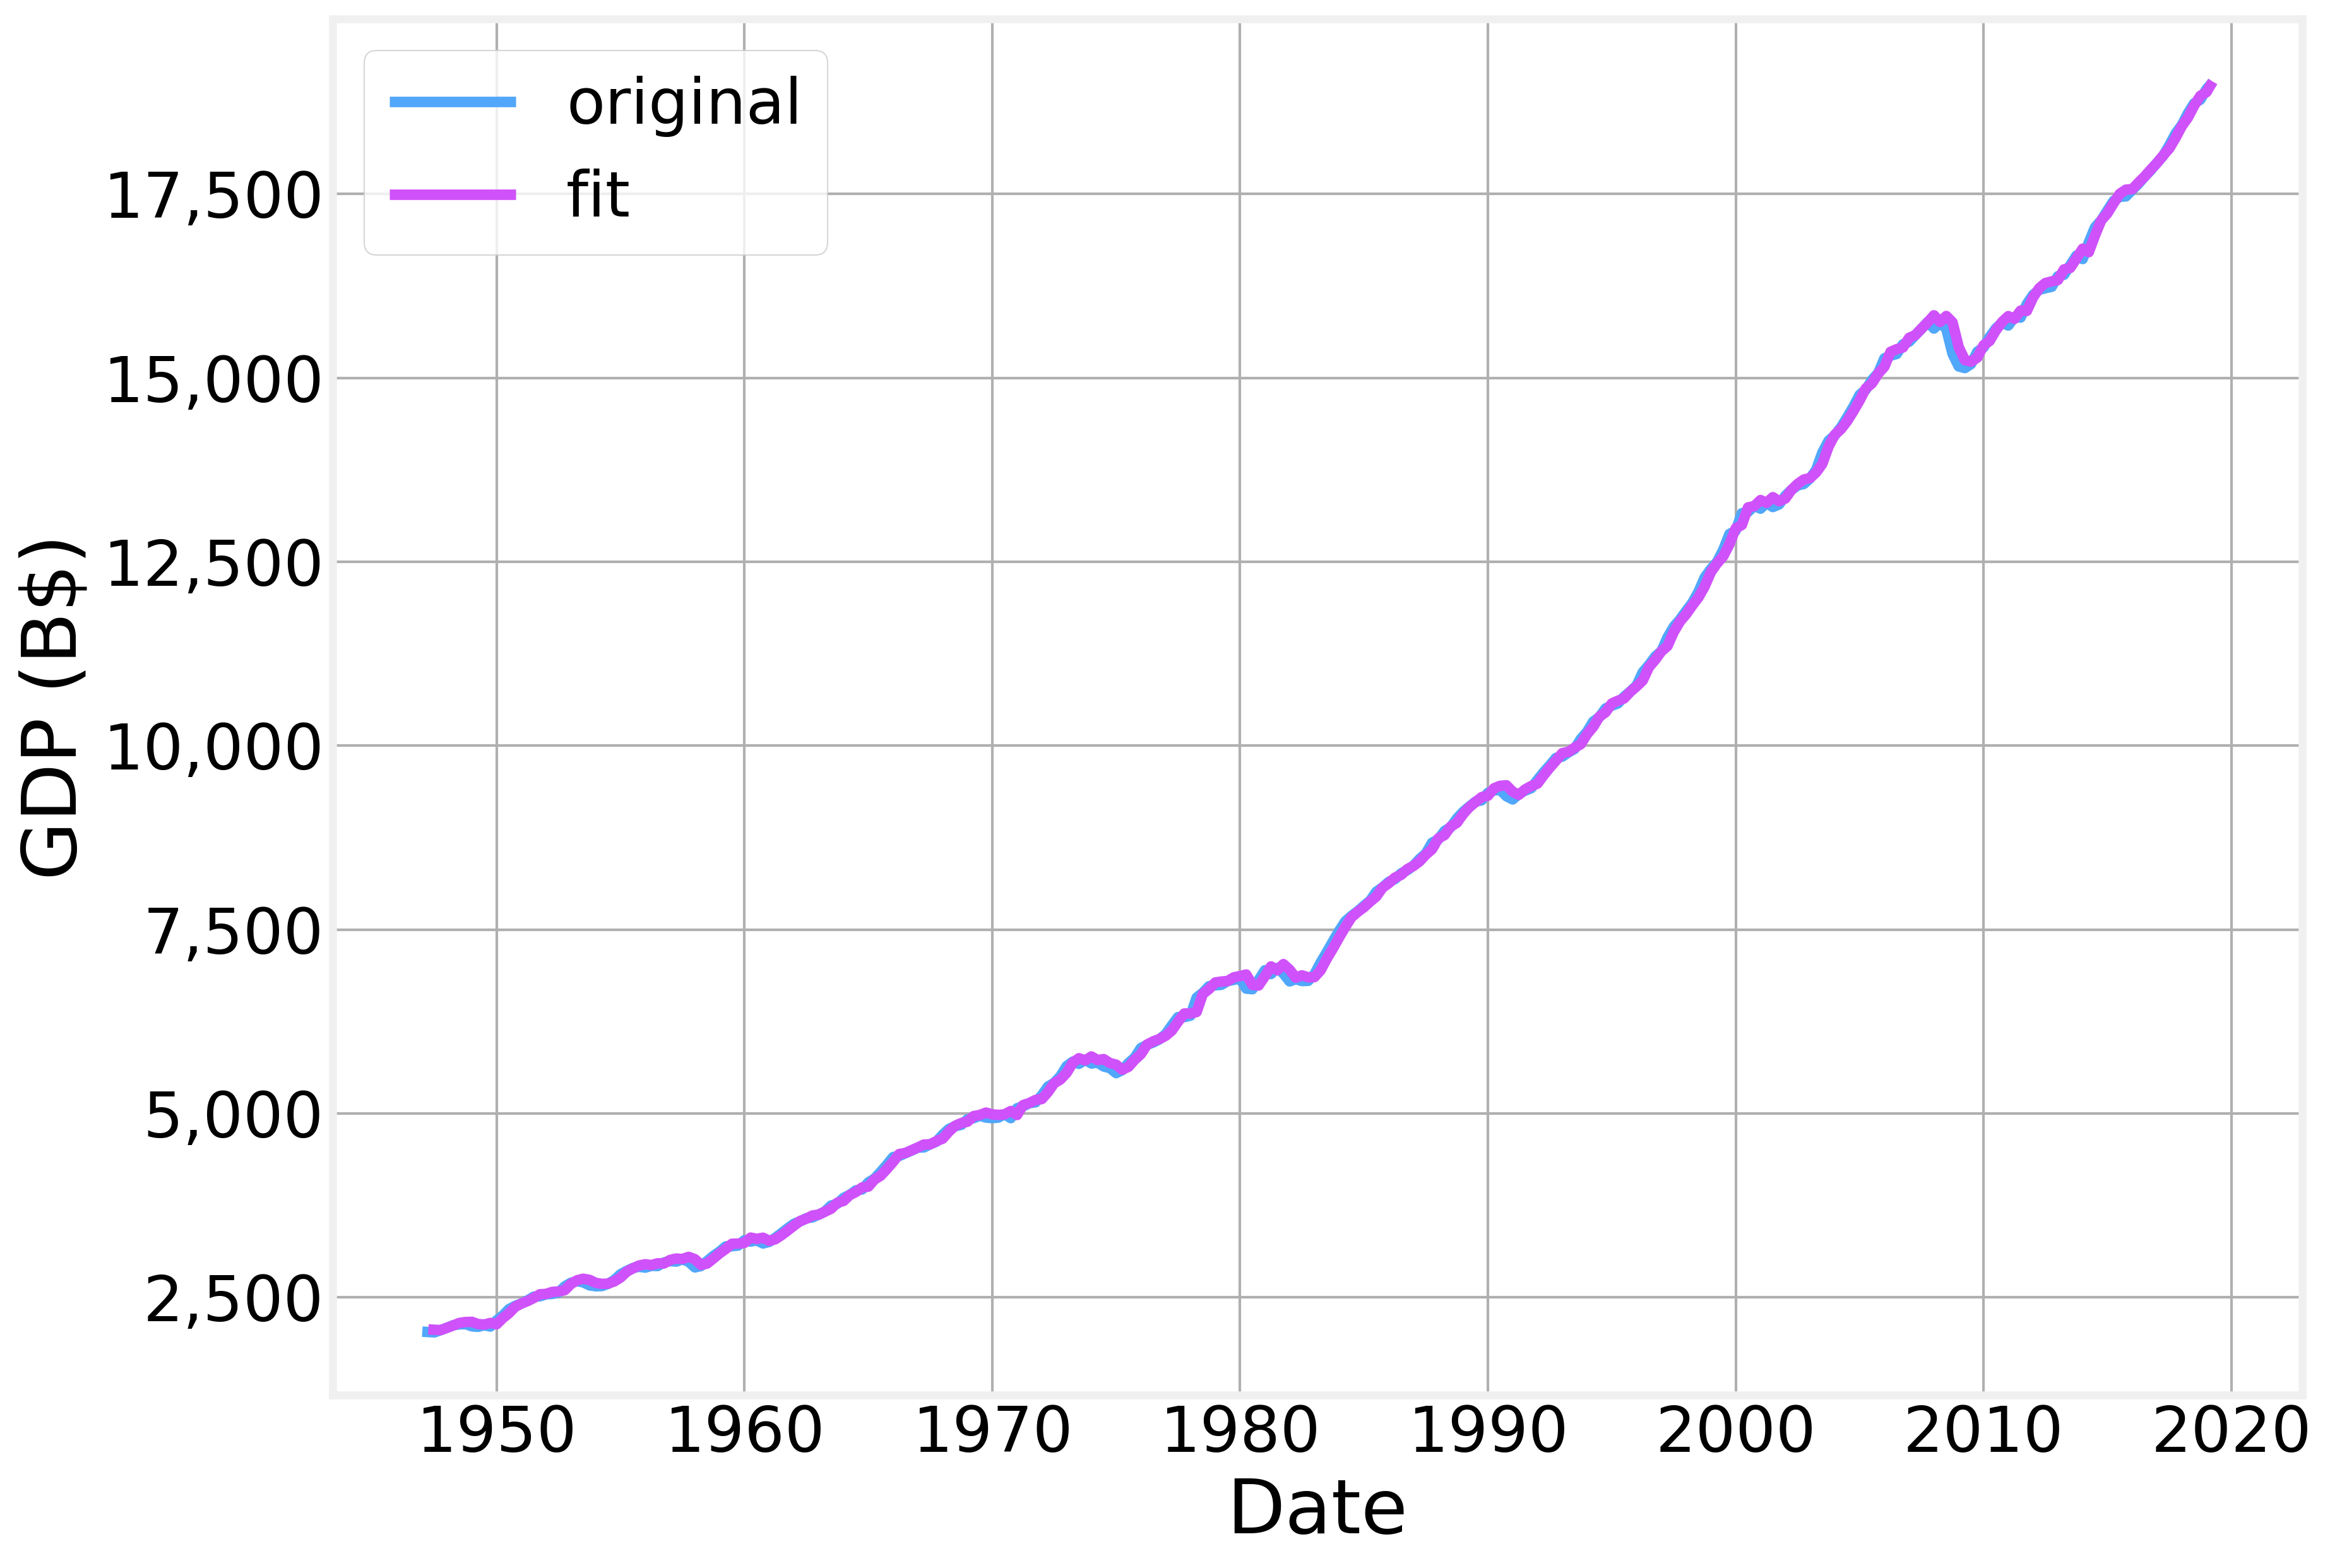

In [8]:
plt.plot(series.index, values, label='original')
plt.plot(series.index[1:], y_pred, label='fit')
plt.xlabel('Date')
plt.ylabel('GDP (B$)')
plt.legend()
plt.gca().get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')));

So, problem solved?

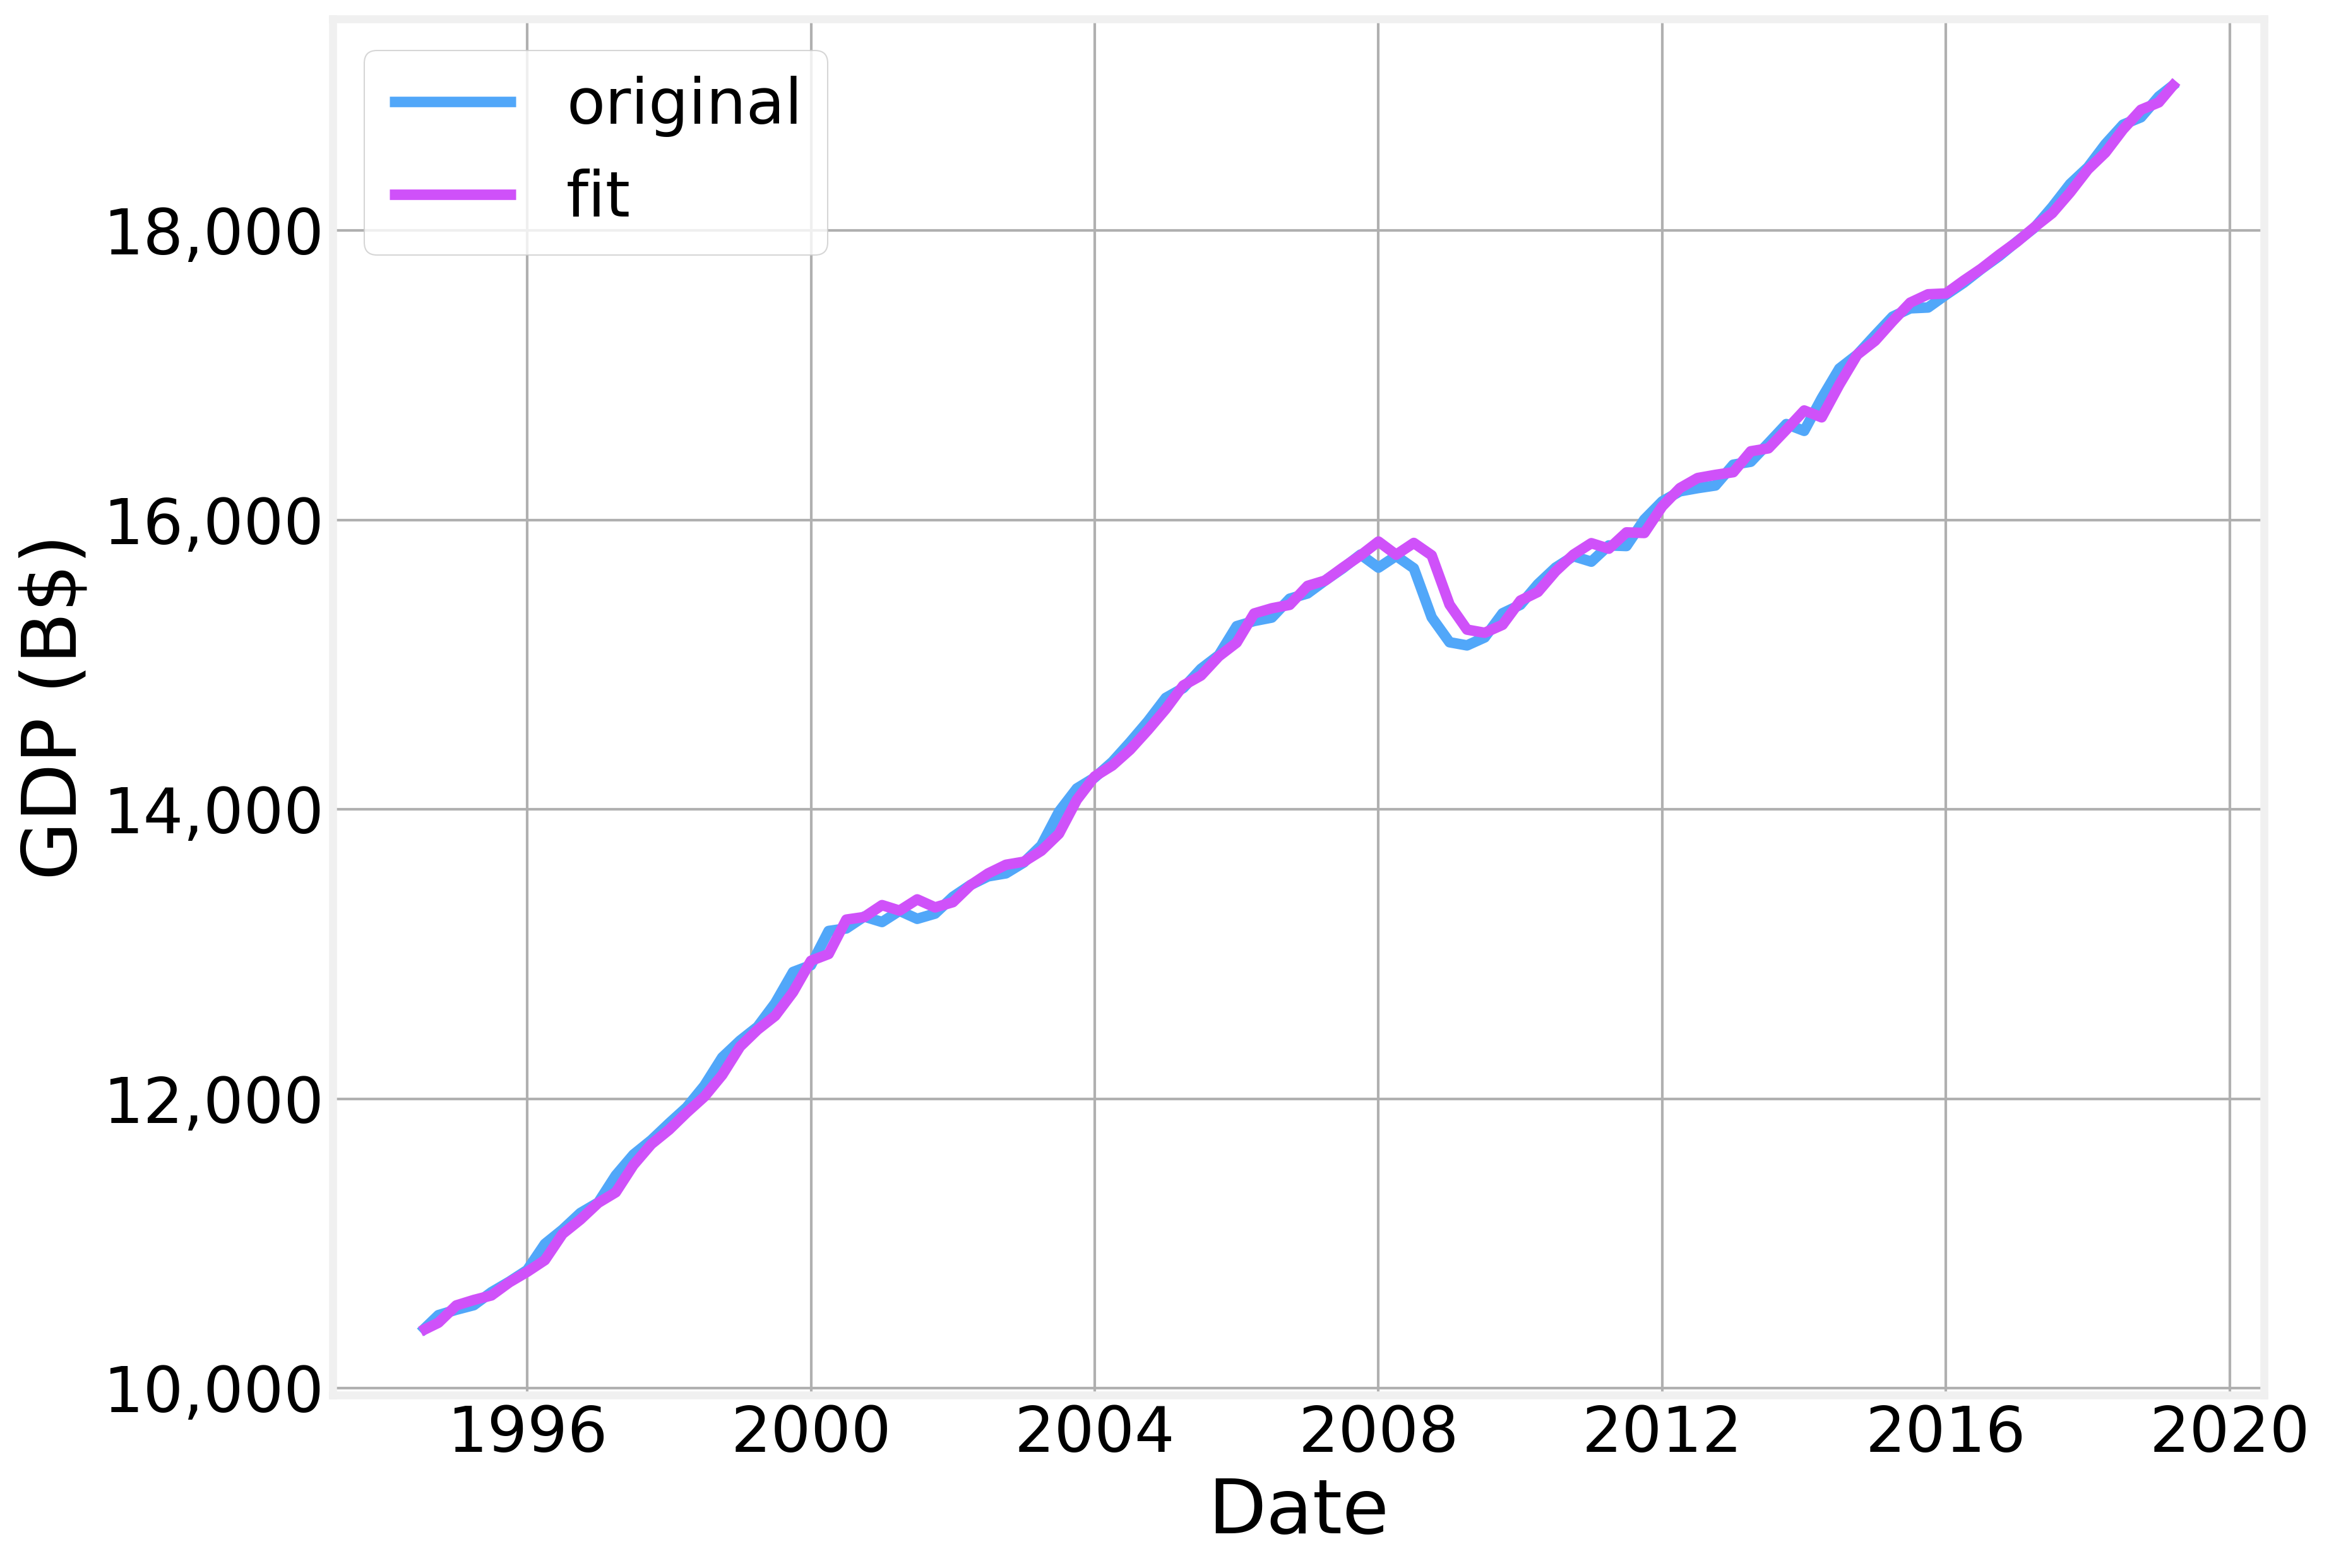

In [9]:
plt.plot(series.index[-100:], values[-100:], label='original')
plt.plot(series.index[-100:], y_pred[-100:], label='fit')
plt.xlabel('Date')
plt.ylabel('GDP (B$)')
plt.legend()
plt.gca().get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')));

Since this series has a strong trending behavior, each point is strongly correlated with the next. If the model simply returns something close to the input value, it will get a very good approximation already. Essentially, we are leaking information in our inputs.

A fairer evaluation would be to have the model predict the next value based on it's own current estimate, at which point the problem becomes obvious

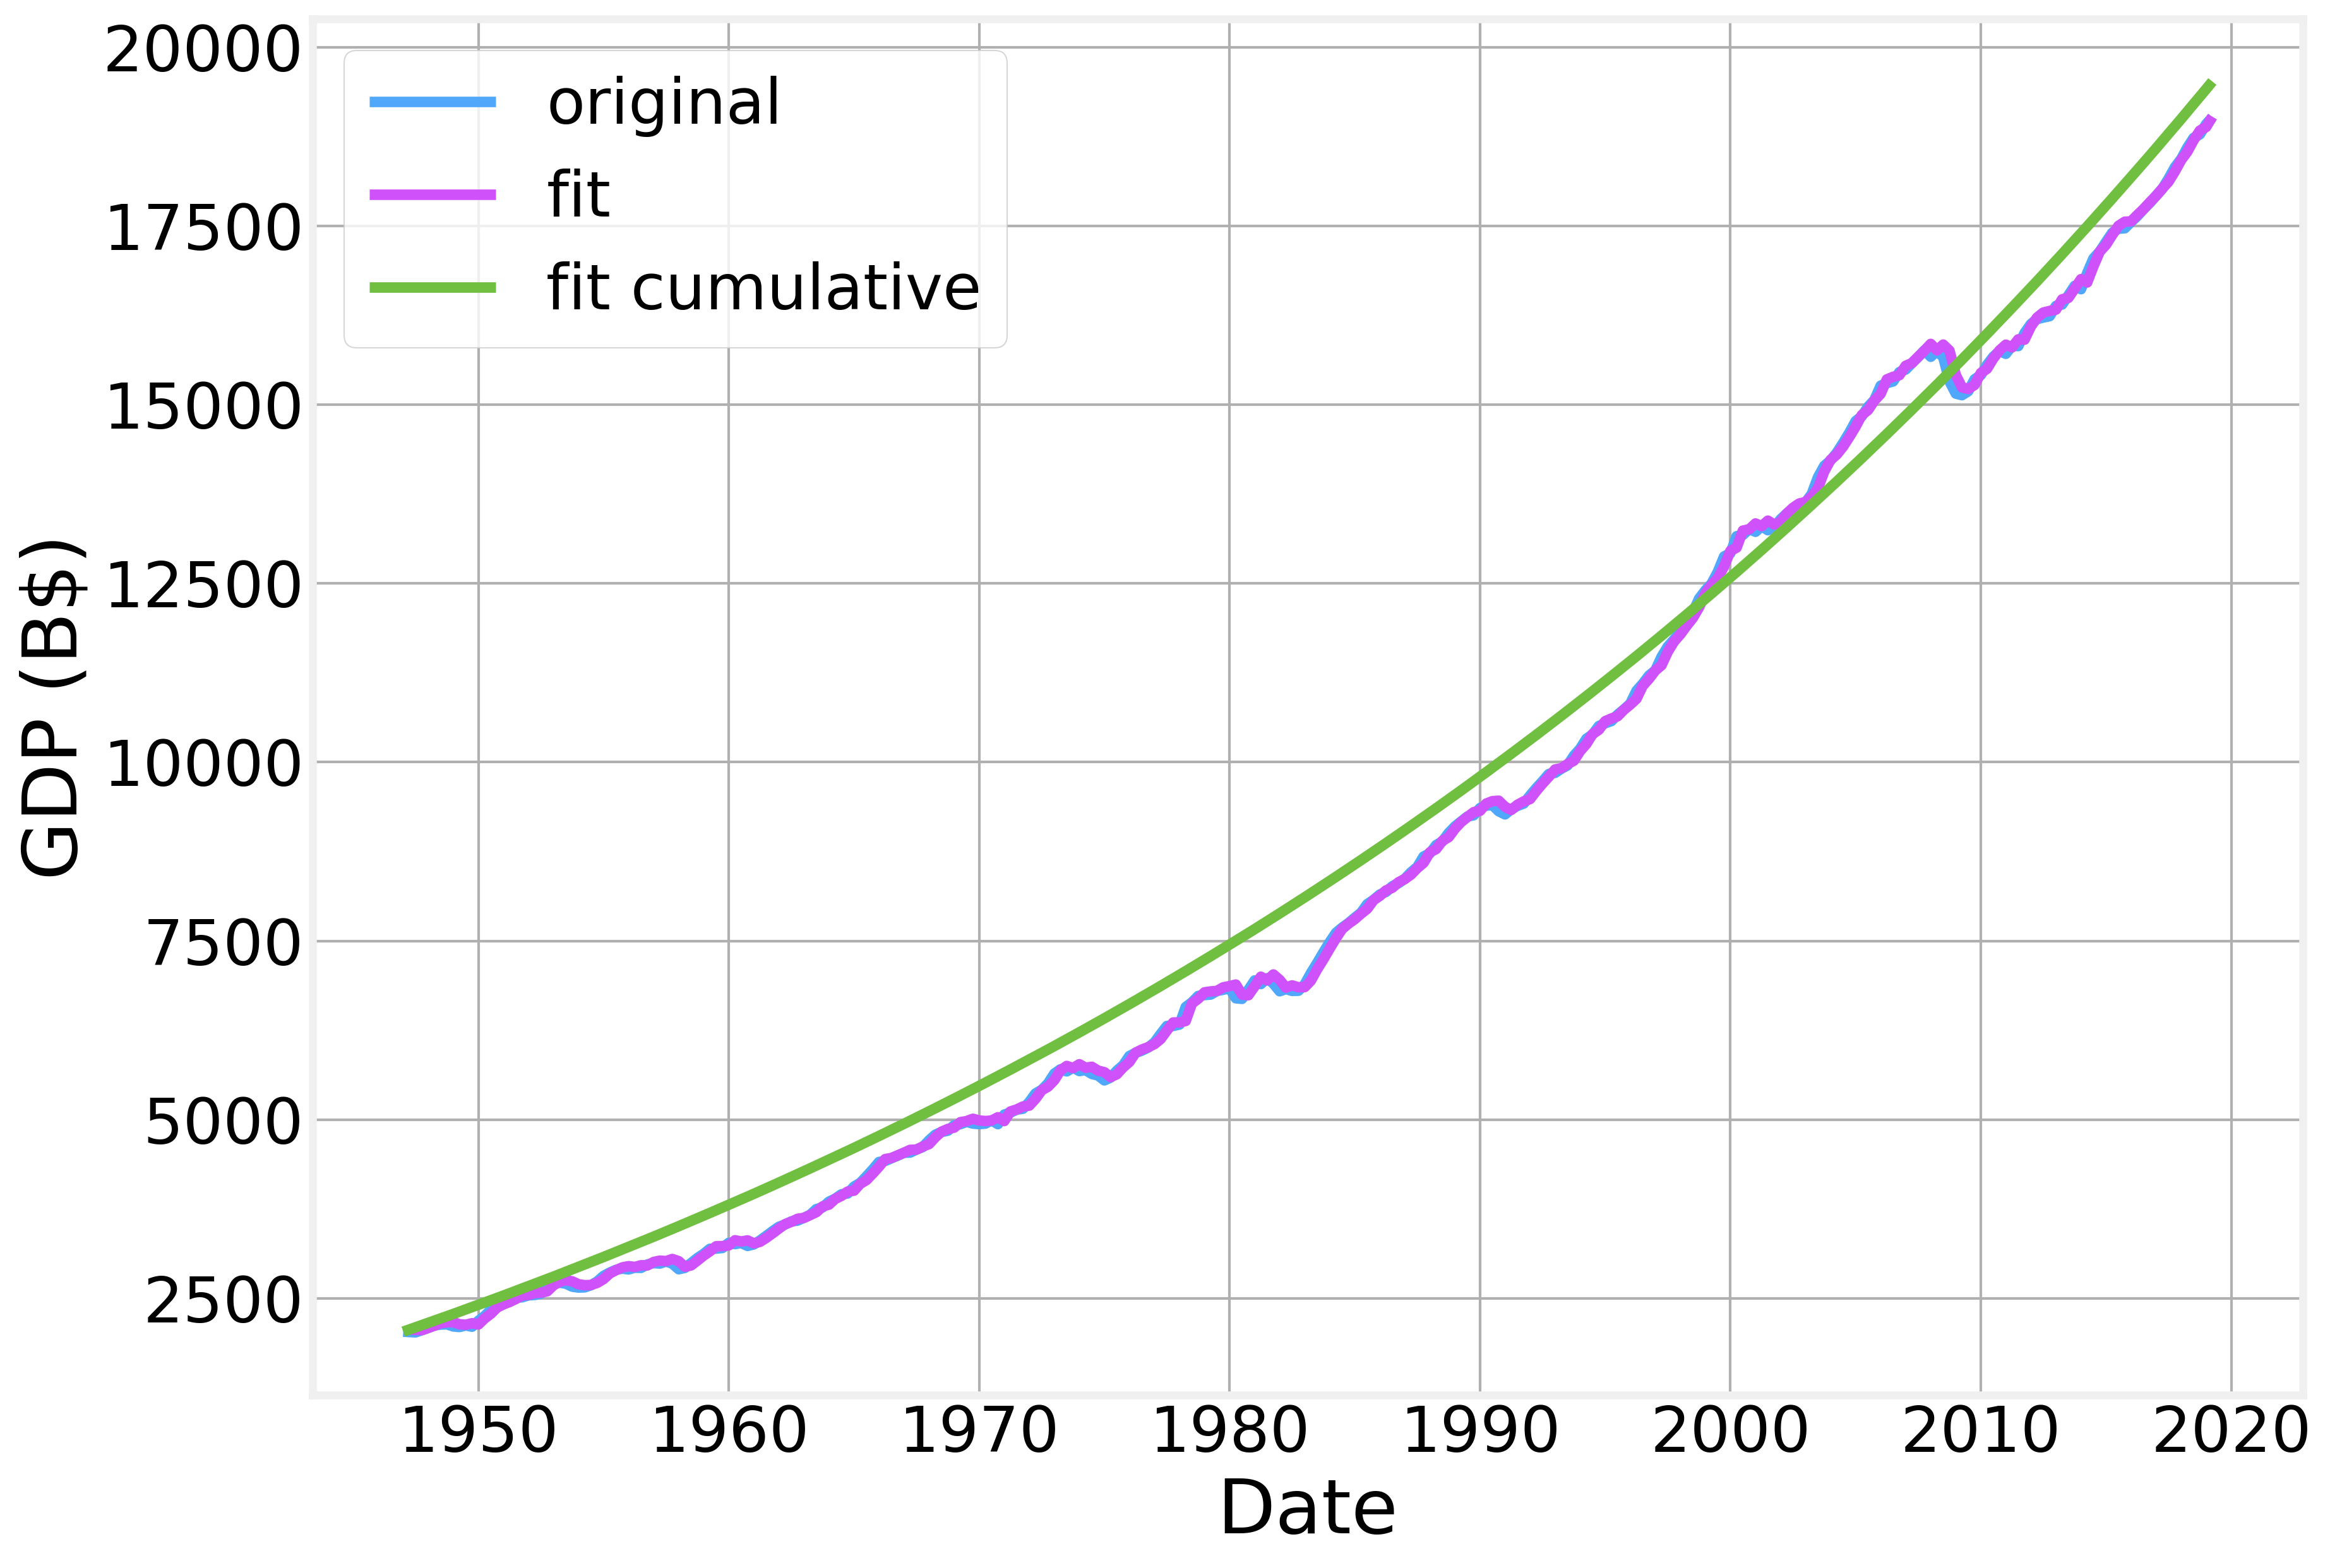

In [10]:
y_pred_cumul = [float(values[0])]

for i in range(1, len(values)):
    y_pred_cumul.append(lm.intercept_+y_pred_cumul[-1]*lm.coef_)
    
plt.plot(series.index, values, label='original')
plt.plot(series.index[1:], y_pred, label='fit')
plt.plot(series.index, y_pred_cumul, label='fit cumulative')
plt.xlabel('Date')
plt.ylabel('GDP (B$)')
plt.legend()
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')));

Our model is simply capturing the trend in the data

## Removing the trend

Since we know there's a trend, we can just use the techniques we learned earlier to detrend the series

### Relative Change

An alternative to differentiating is taking the relative change 

$$\mathrm{relative~change}=\frac{y_{t+1}}{y_t}-1$$. 

Pandas provides us with the __pct_change()__ function to acomplish this

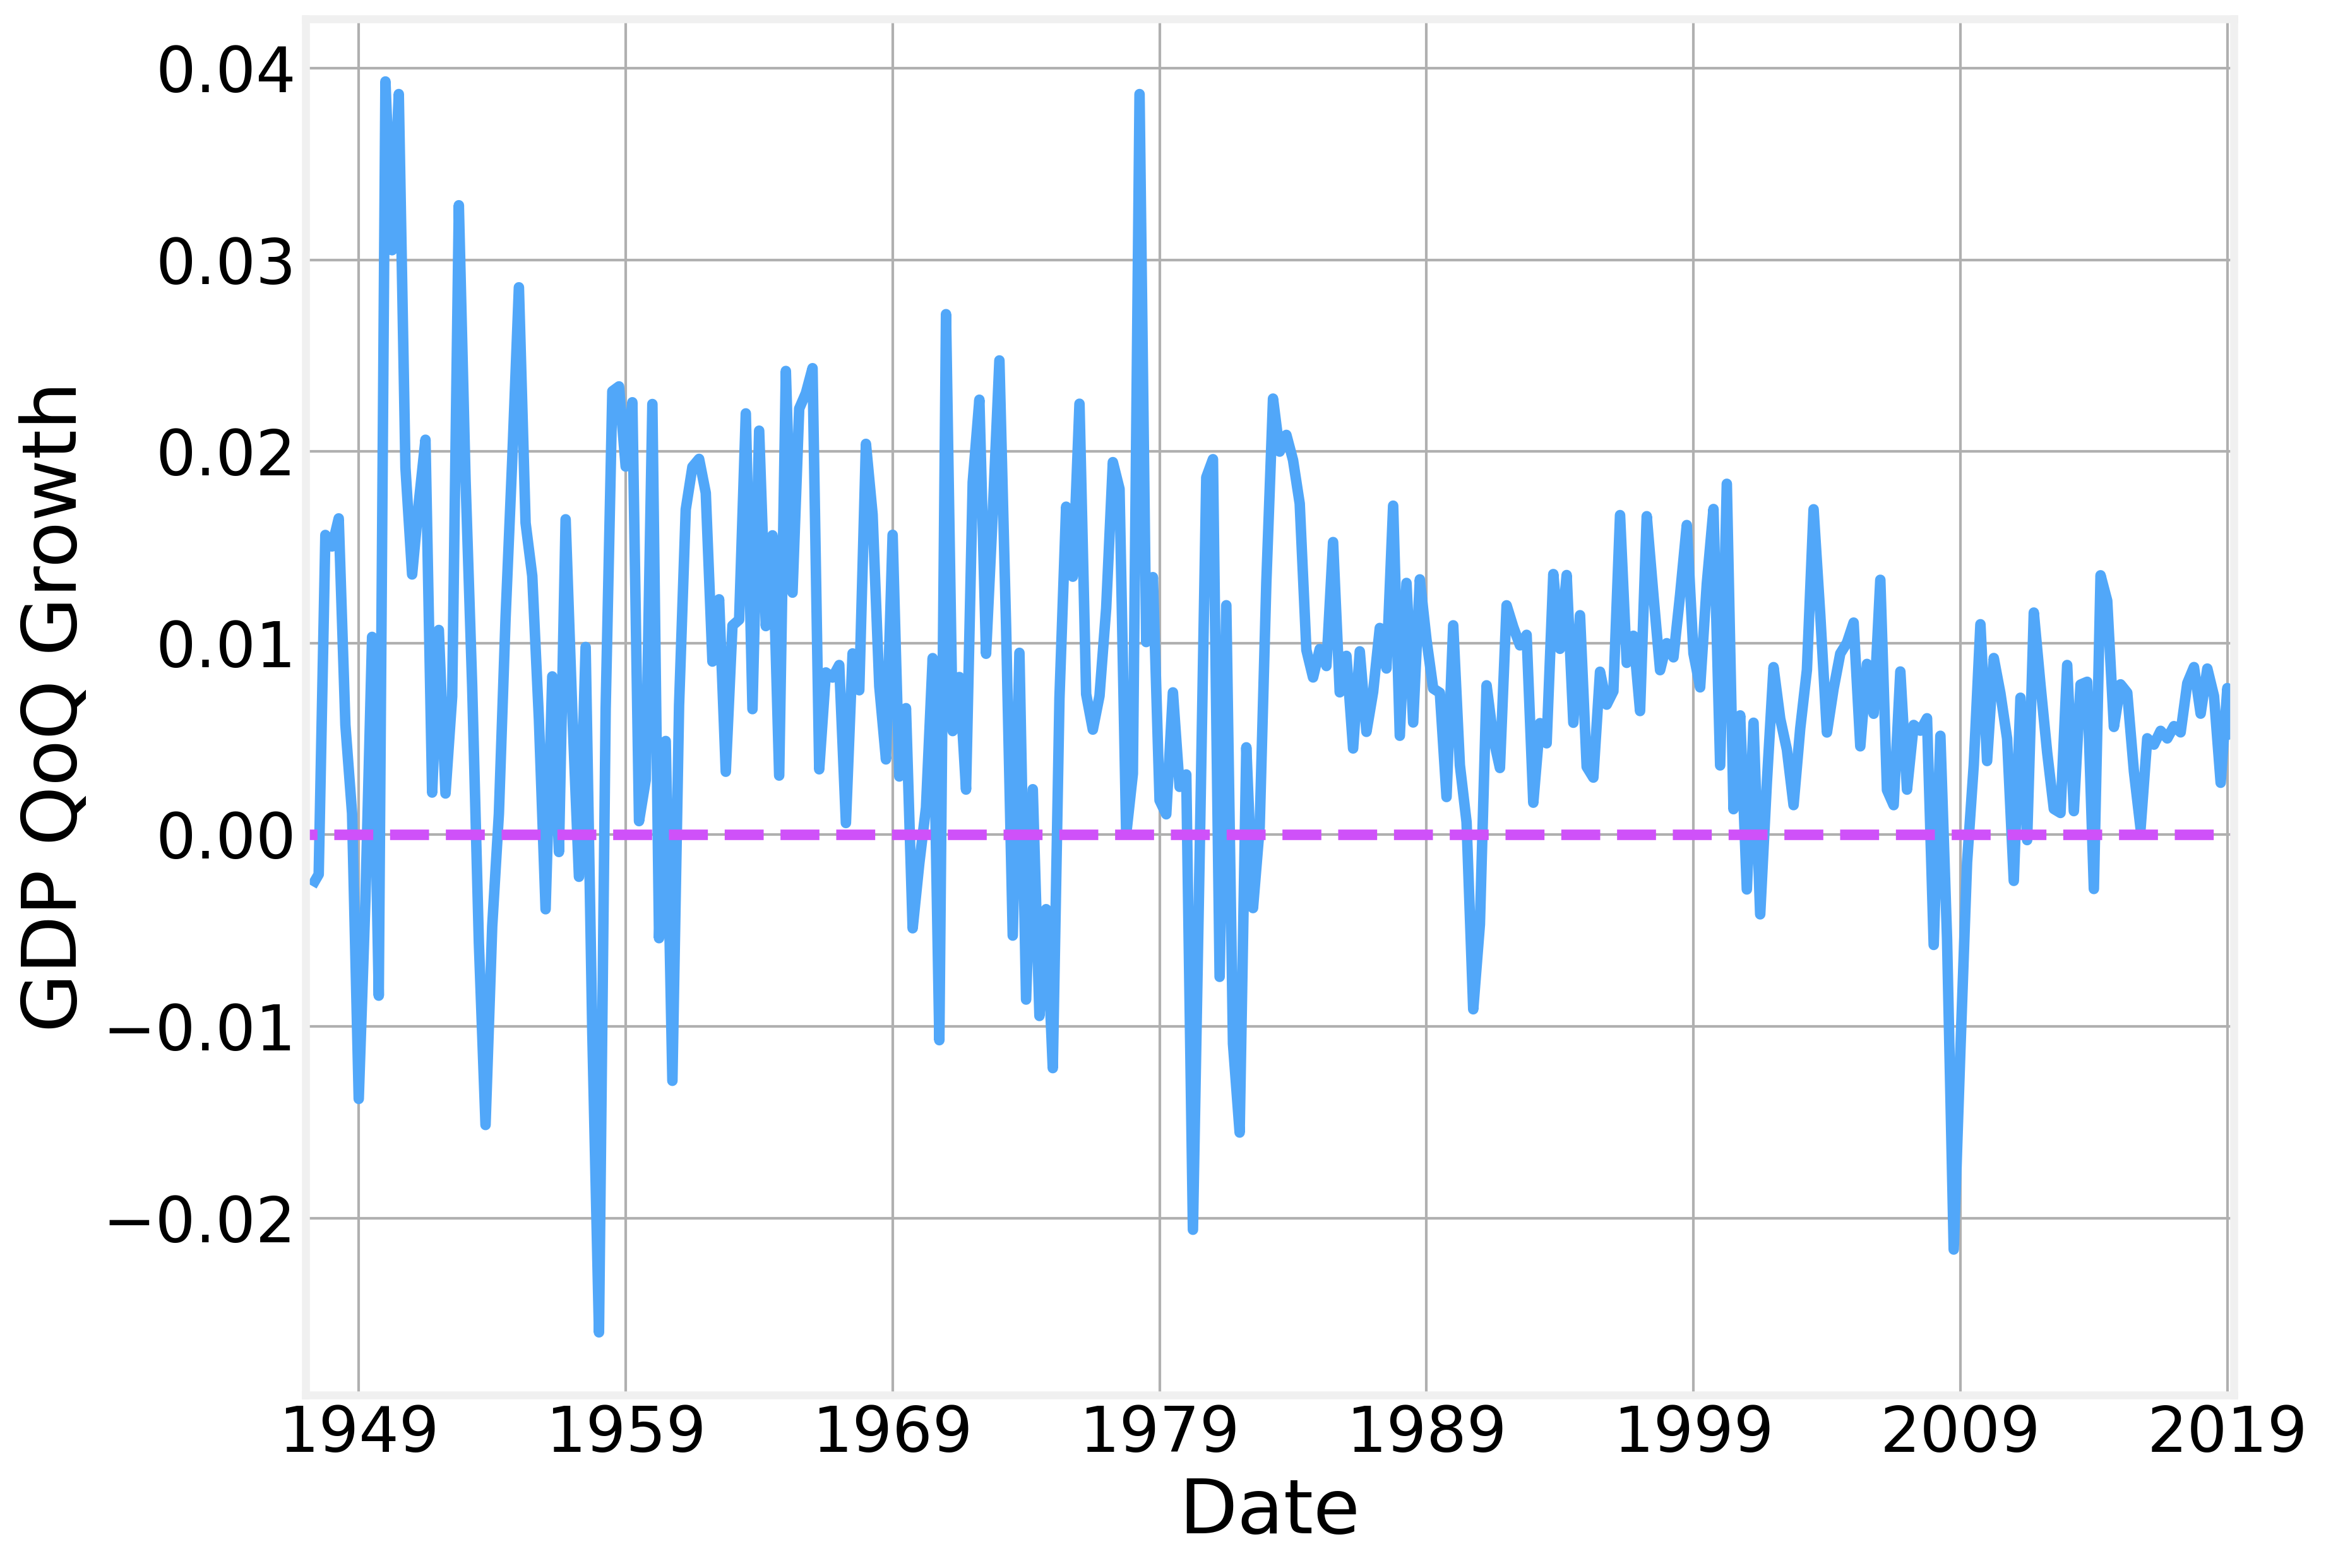

In [11]:
ax = series['GDP'].pct_change().plot()
ax.plot([series.index.min(), series.index.max()], [0, 0], '--')
ax.set_xlabel('Date')
ax.set_ylabel('GDP QoQ Growth');

Now we see that the resulting time series is much more stationary

## Autocorrelation function

Let's take a quick look at the autocorrelation function of the original and detrended series. For simplicity we use the __autocorrelation_plot()__ function from pandas

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

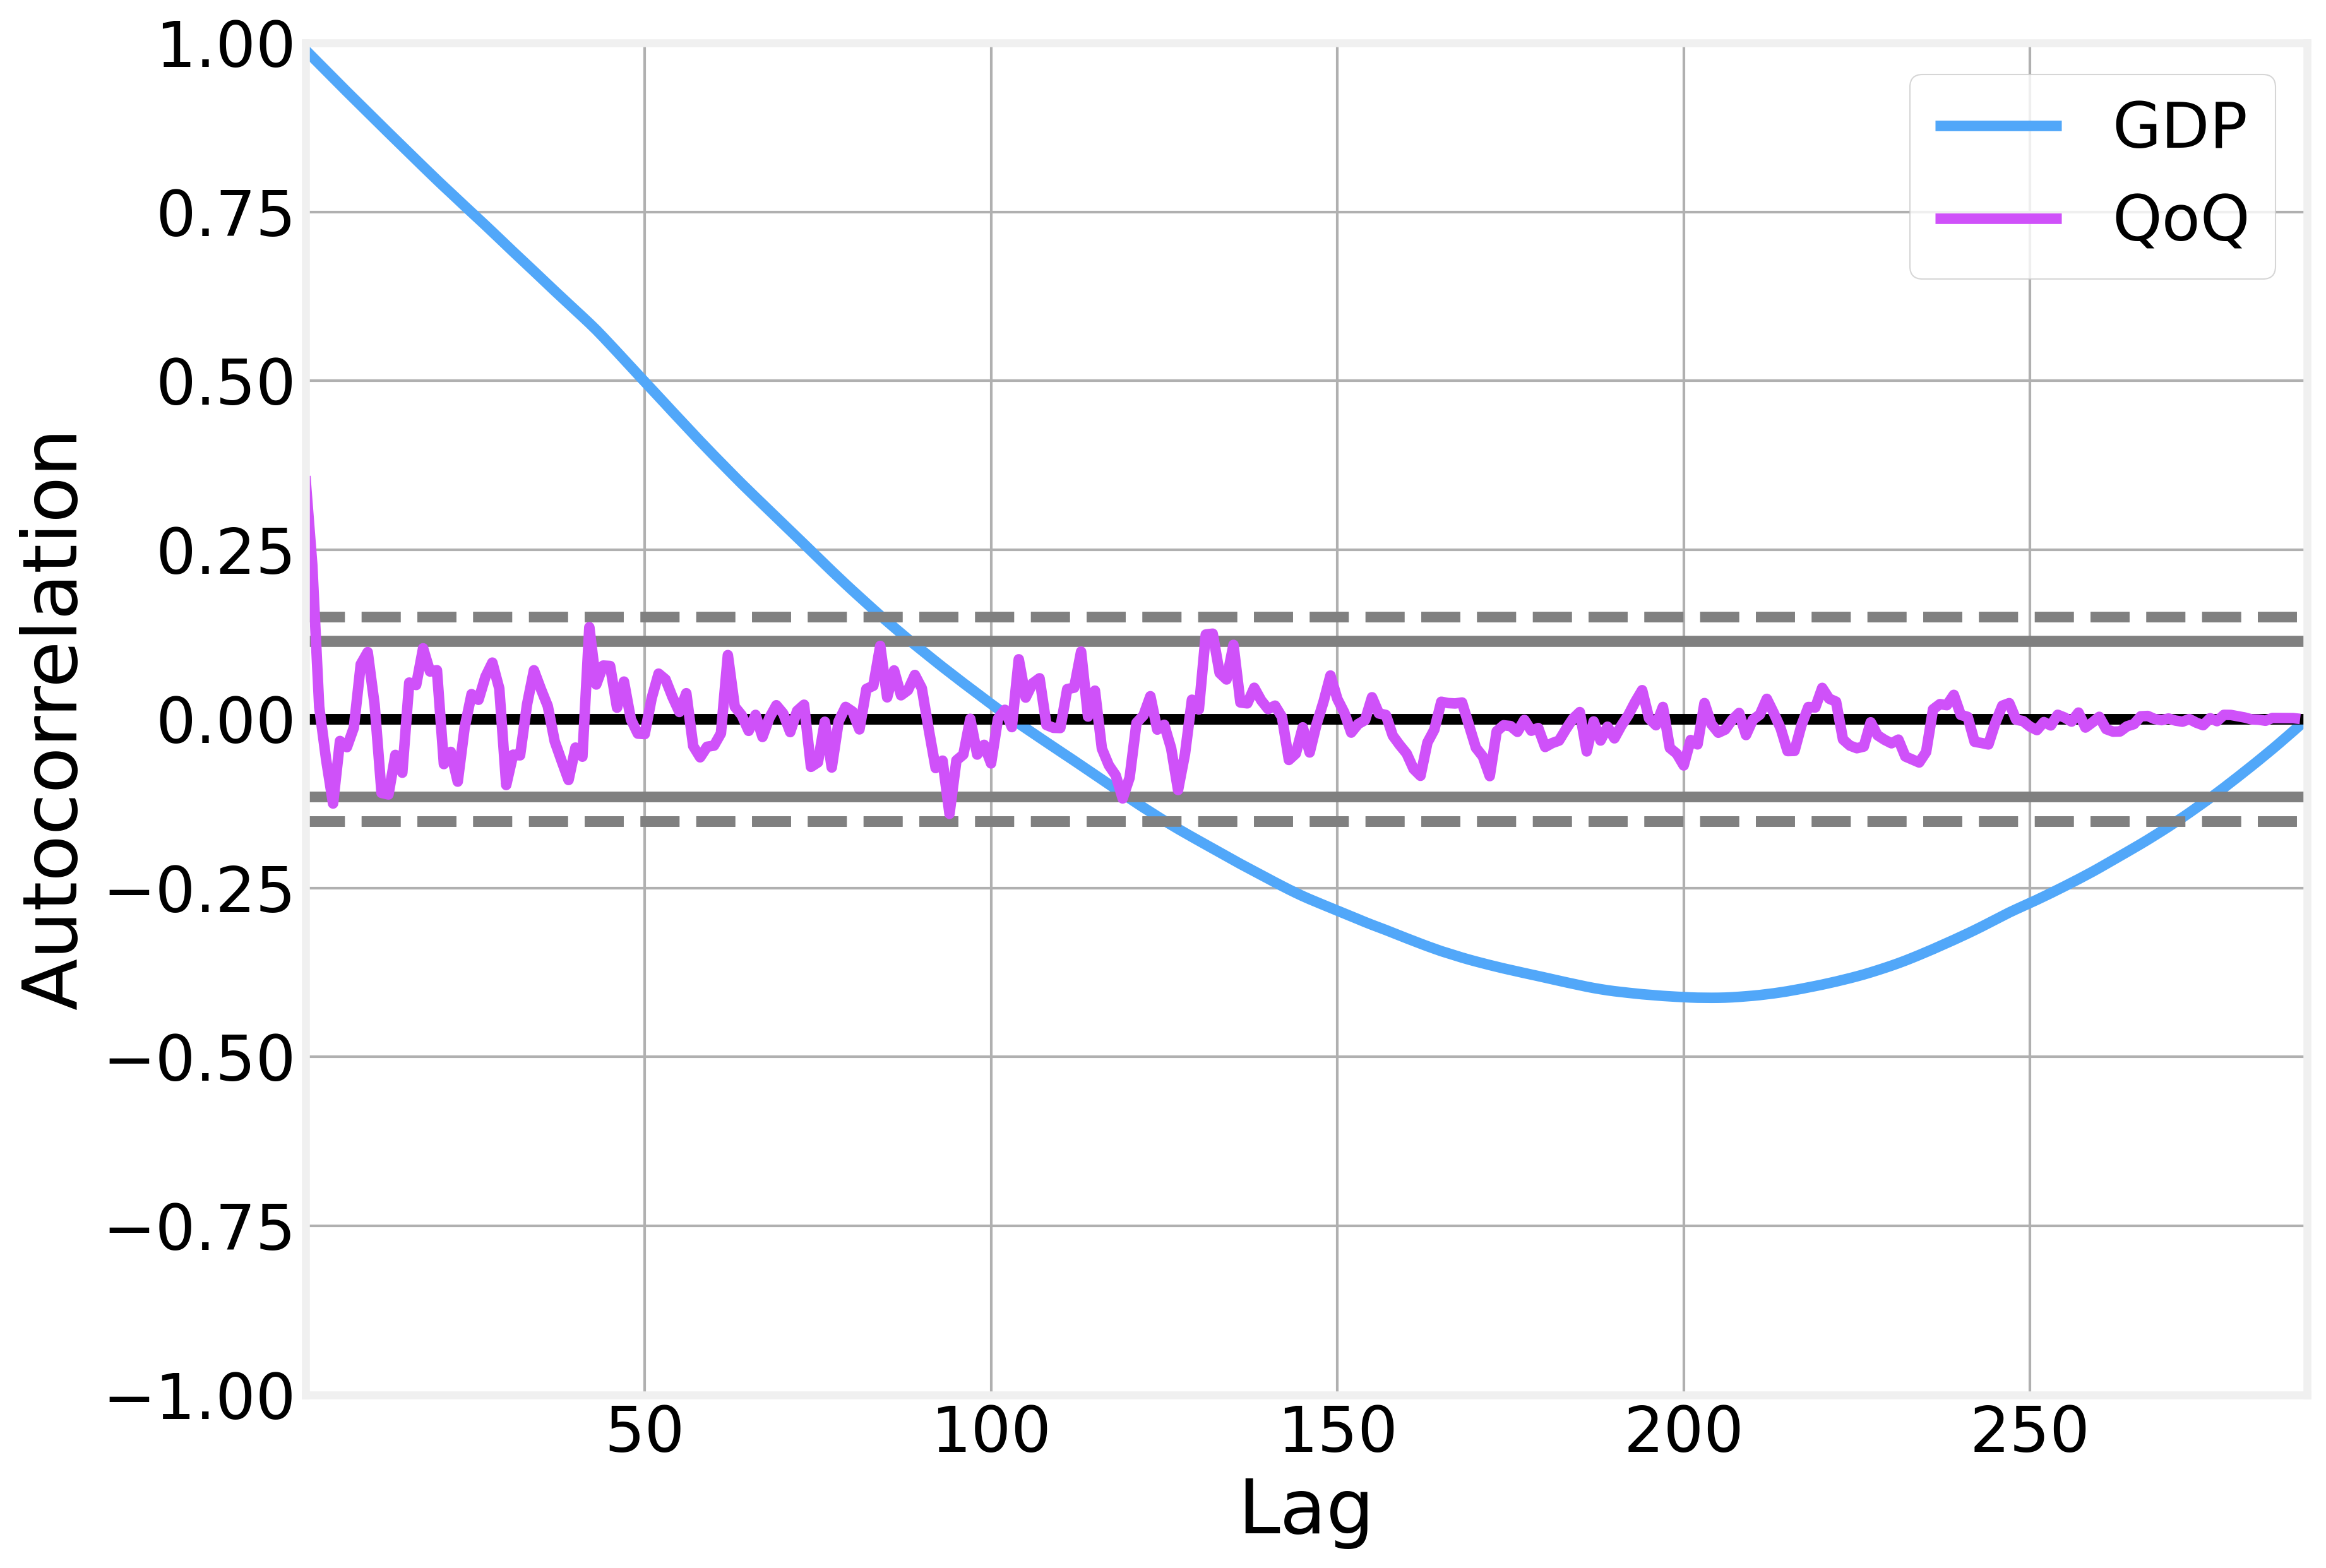

In [12]:
ax = autocorrelation_plot(series, label='GDP')
autocorrelation_plot(series.pct_change().dropna(), ax=ax, label='QoQ')

Now we can be certain that we have removed any significant trending behavior. Let's take another look at how consecutive points look like

Text(0, 0.5, '$x_{t+1}$')

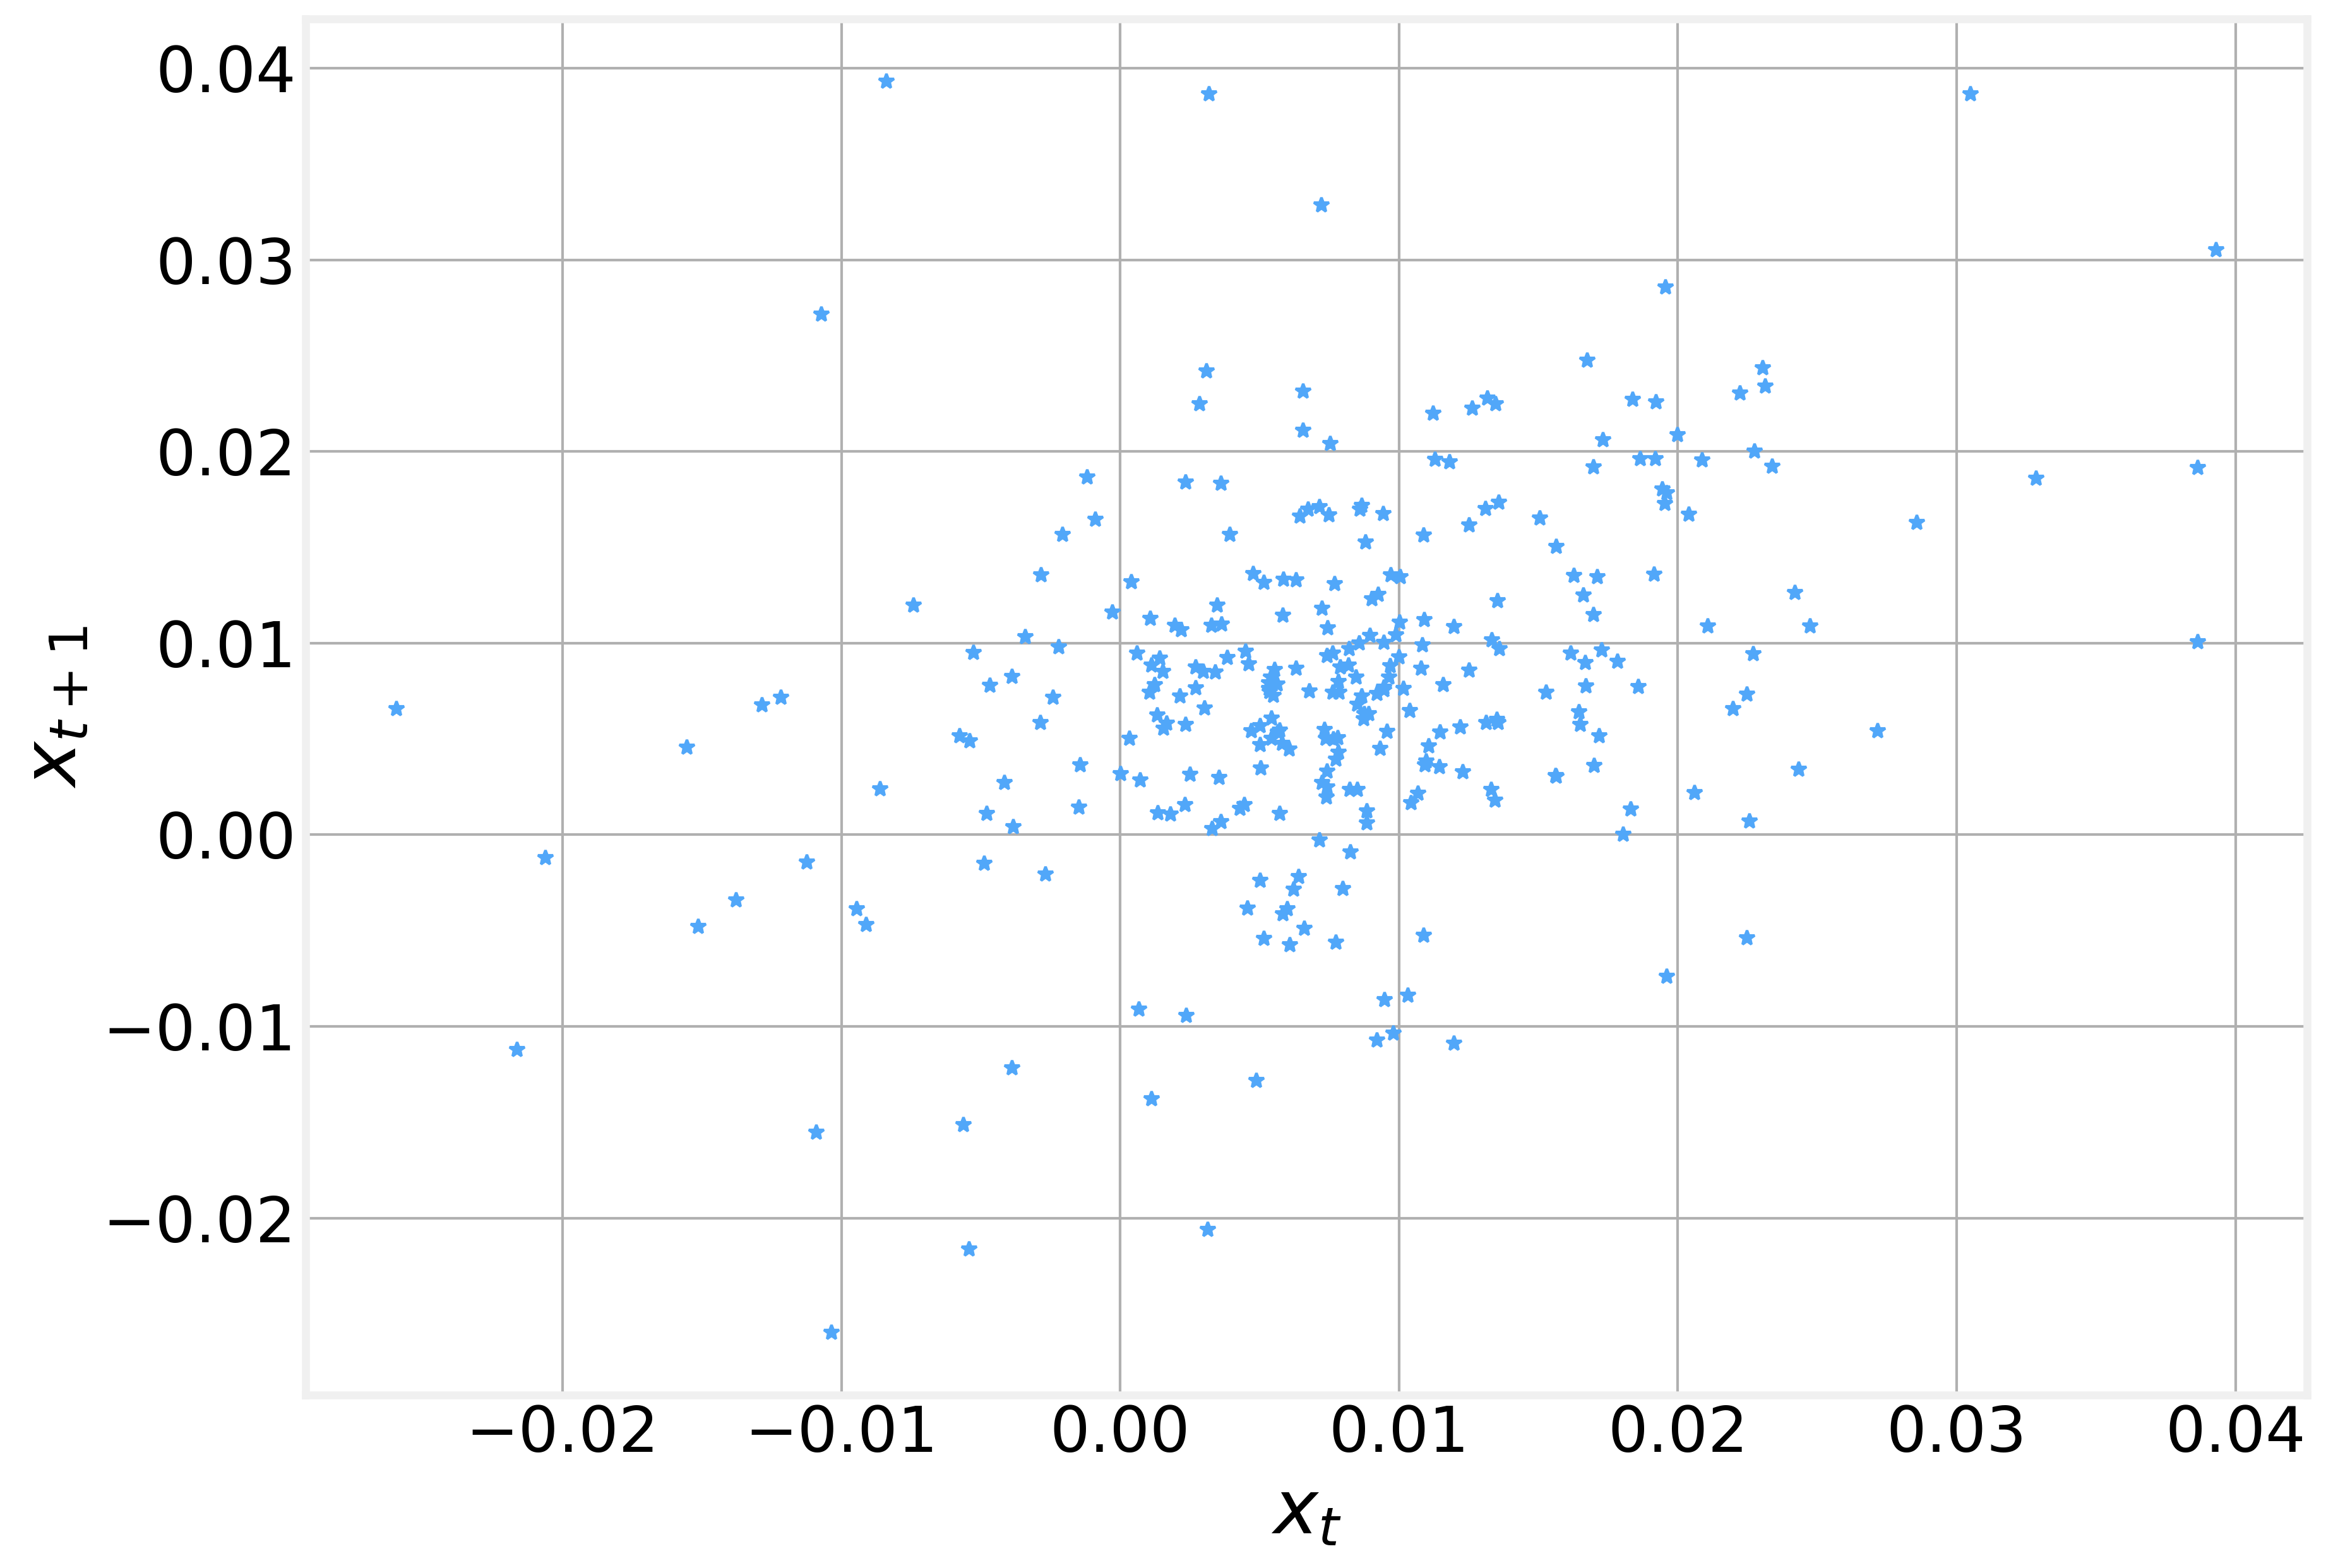

In [13]:
values = series.pct_change().dropna().values.reshape(-1, 1)
X = values[:-1]
y = values[1:]

plt.plot(X.flatten(), y, '*')
plt.xlabel(r'$x_t$')
plt.ylabel(r'$x_{t+1}$')

Can we predict $x_{t+1}$ by performing a linear regression on $x_t$?

In [14]:
lm = LinearRegression()
lm.fit(X, y)

LinearRegression()

In [15]:
y_pred = lm.predict(X)

It doesn't look too shabby... 

Text(0, 0.5, '$x_{t+1}$')

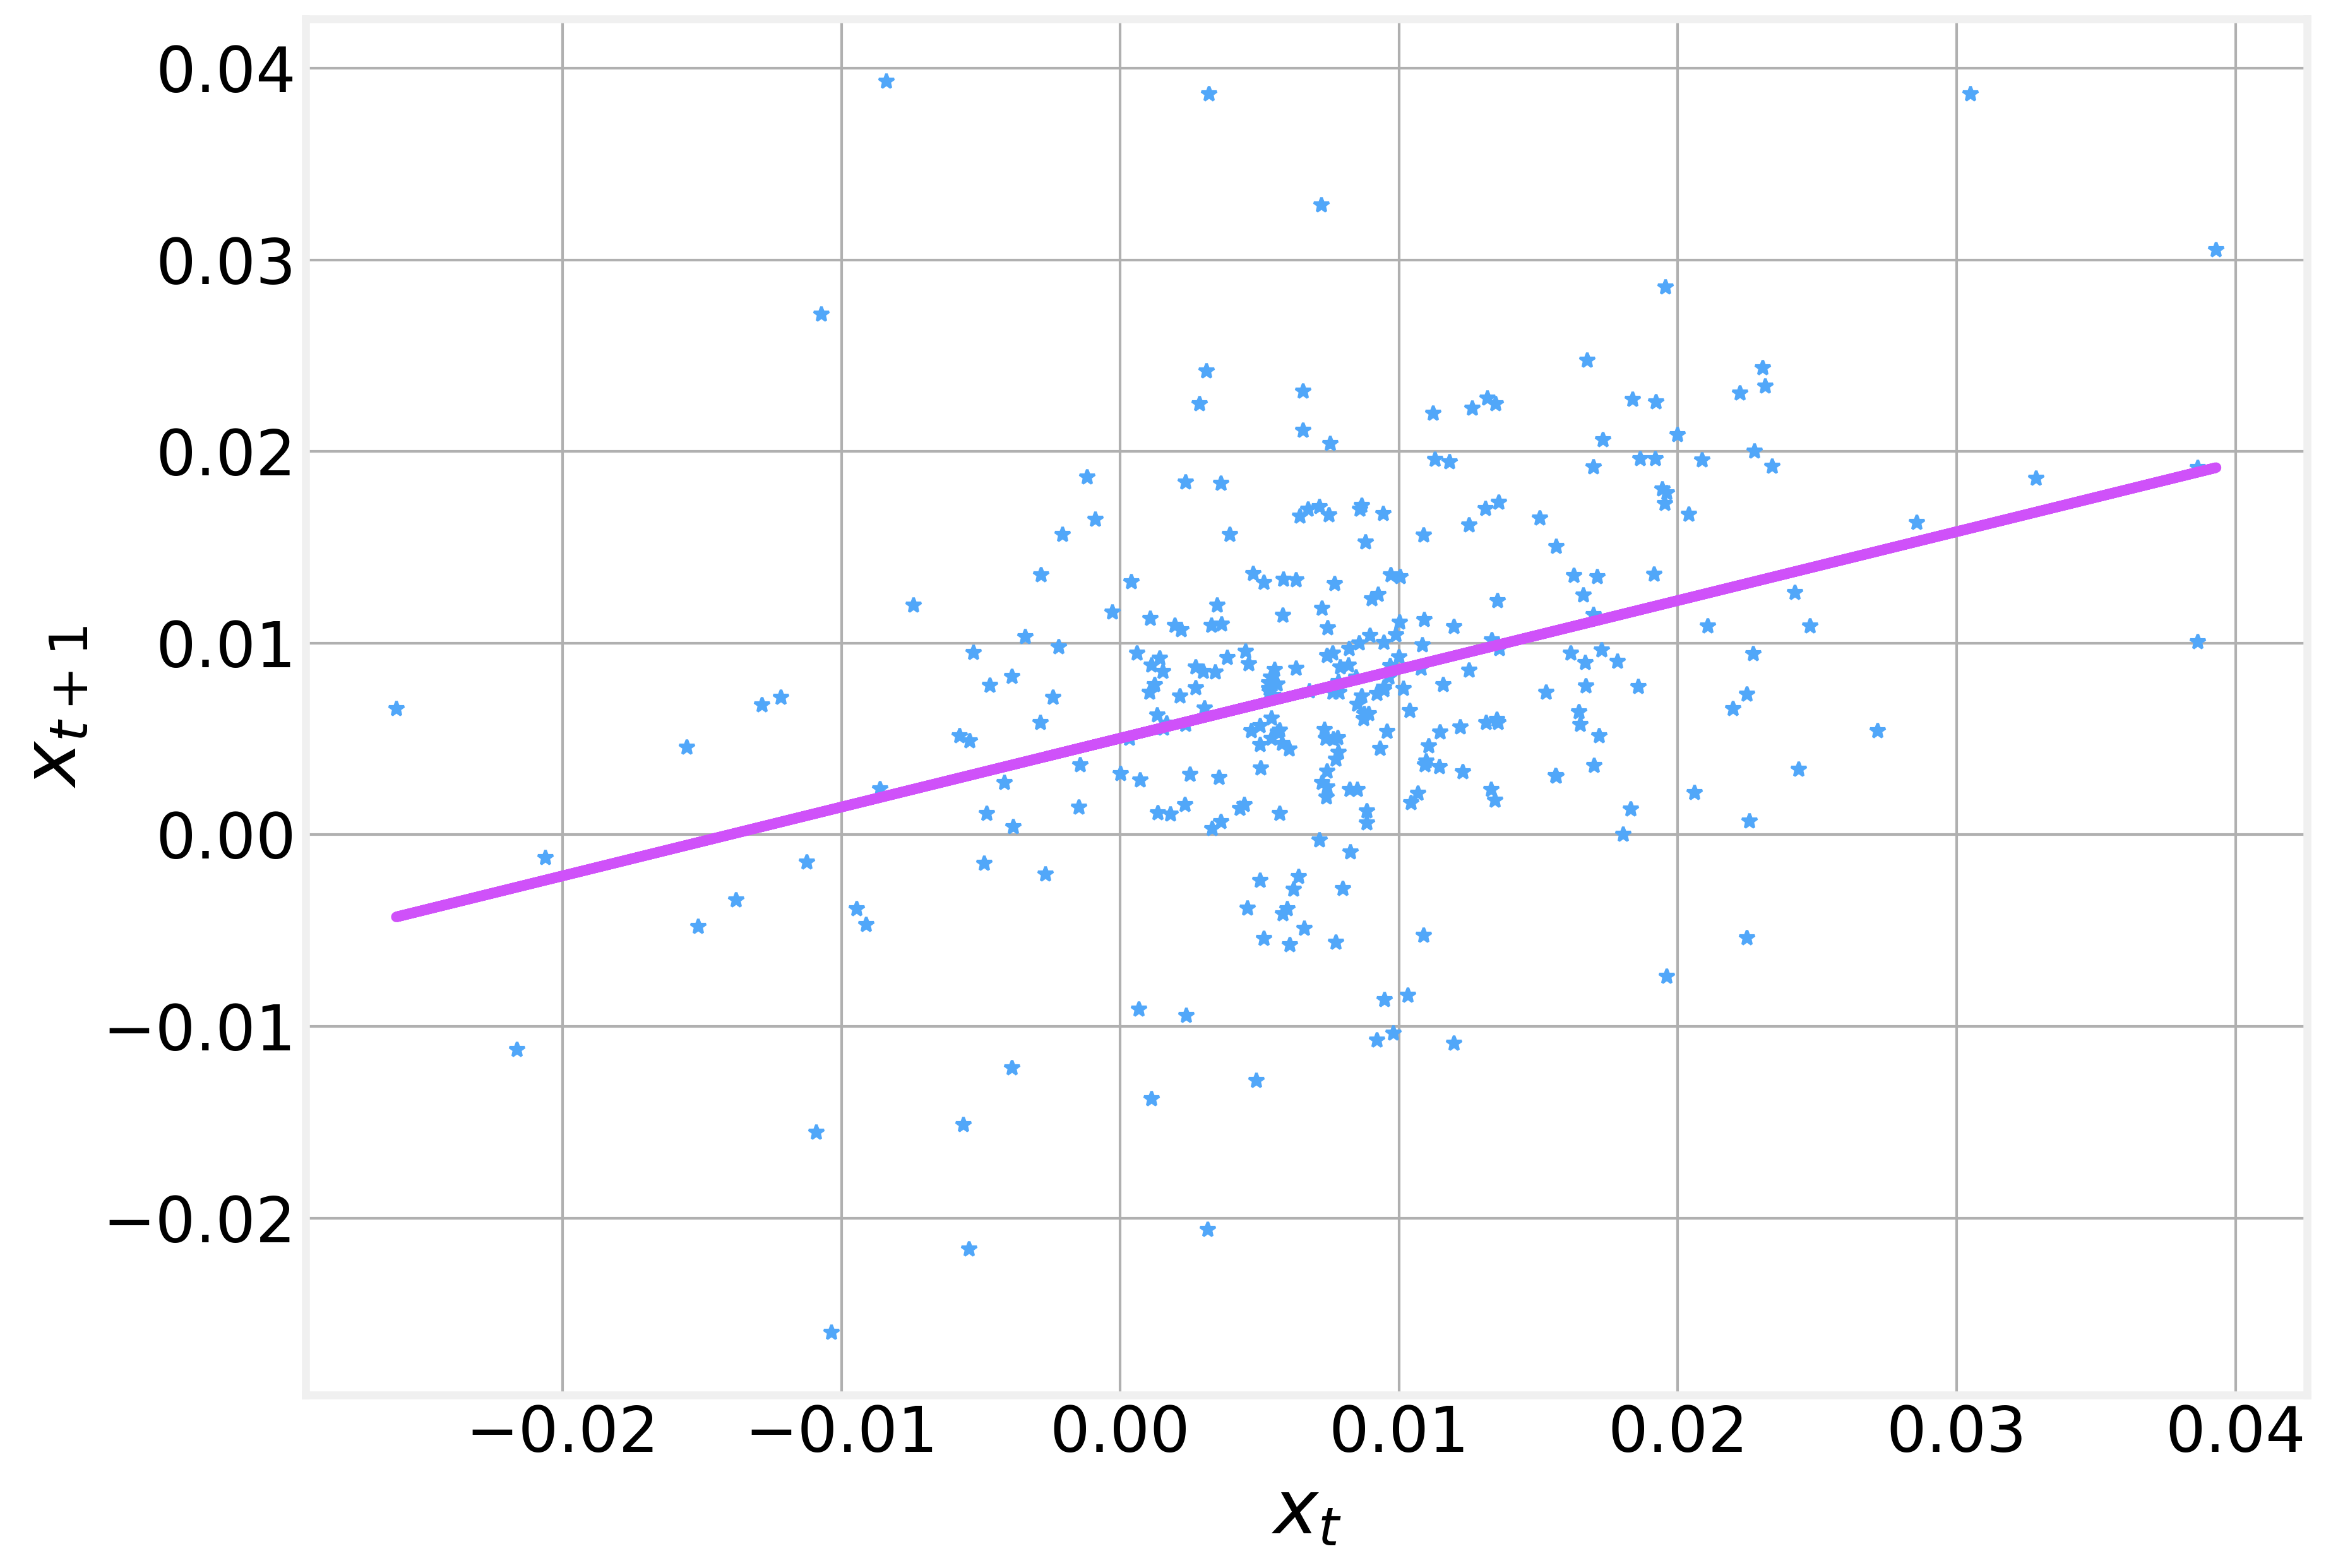

In [16]:
plt.plot(X.flatten(), y, '*')
plt.plot(X.flatten(), y_pred, '-')
plt.xlabel(r'$x_t$')
plt.ylabel(r'$x_{t+1}$')

## Fit comparison

Now we can reconstruct the original signal based on our fit. Since we are using relative differences, we have to invert the equation above when reconstructing the timeseries

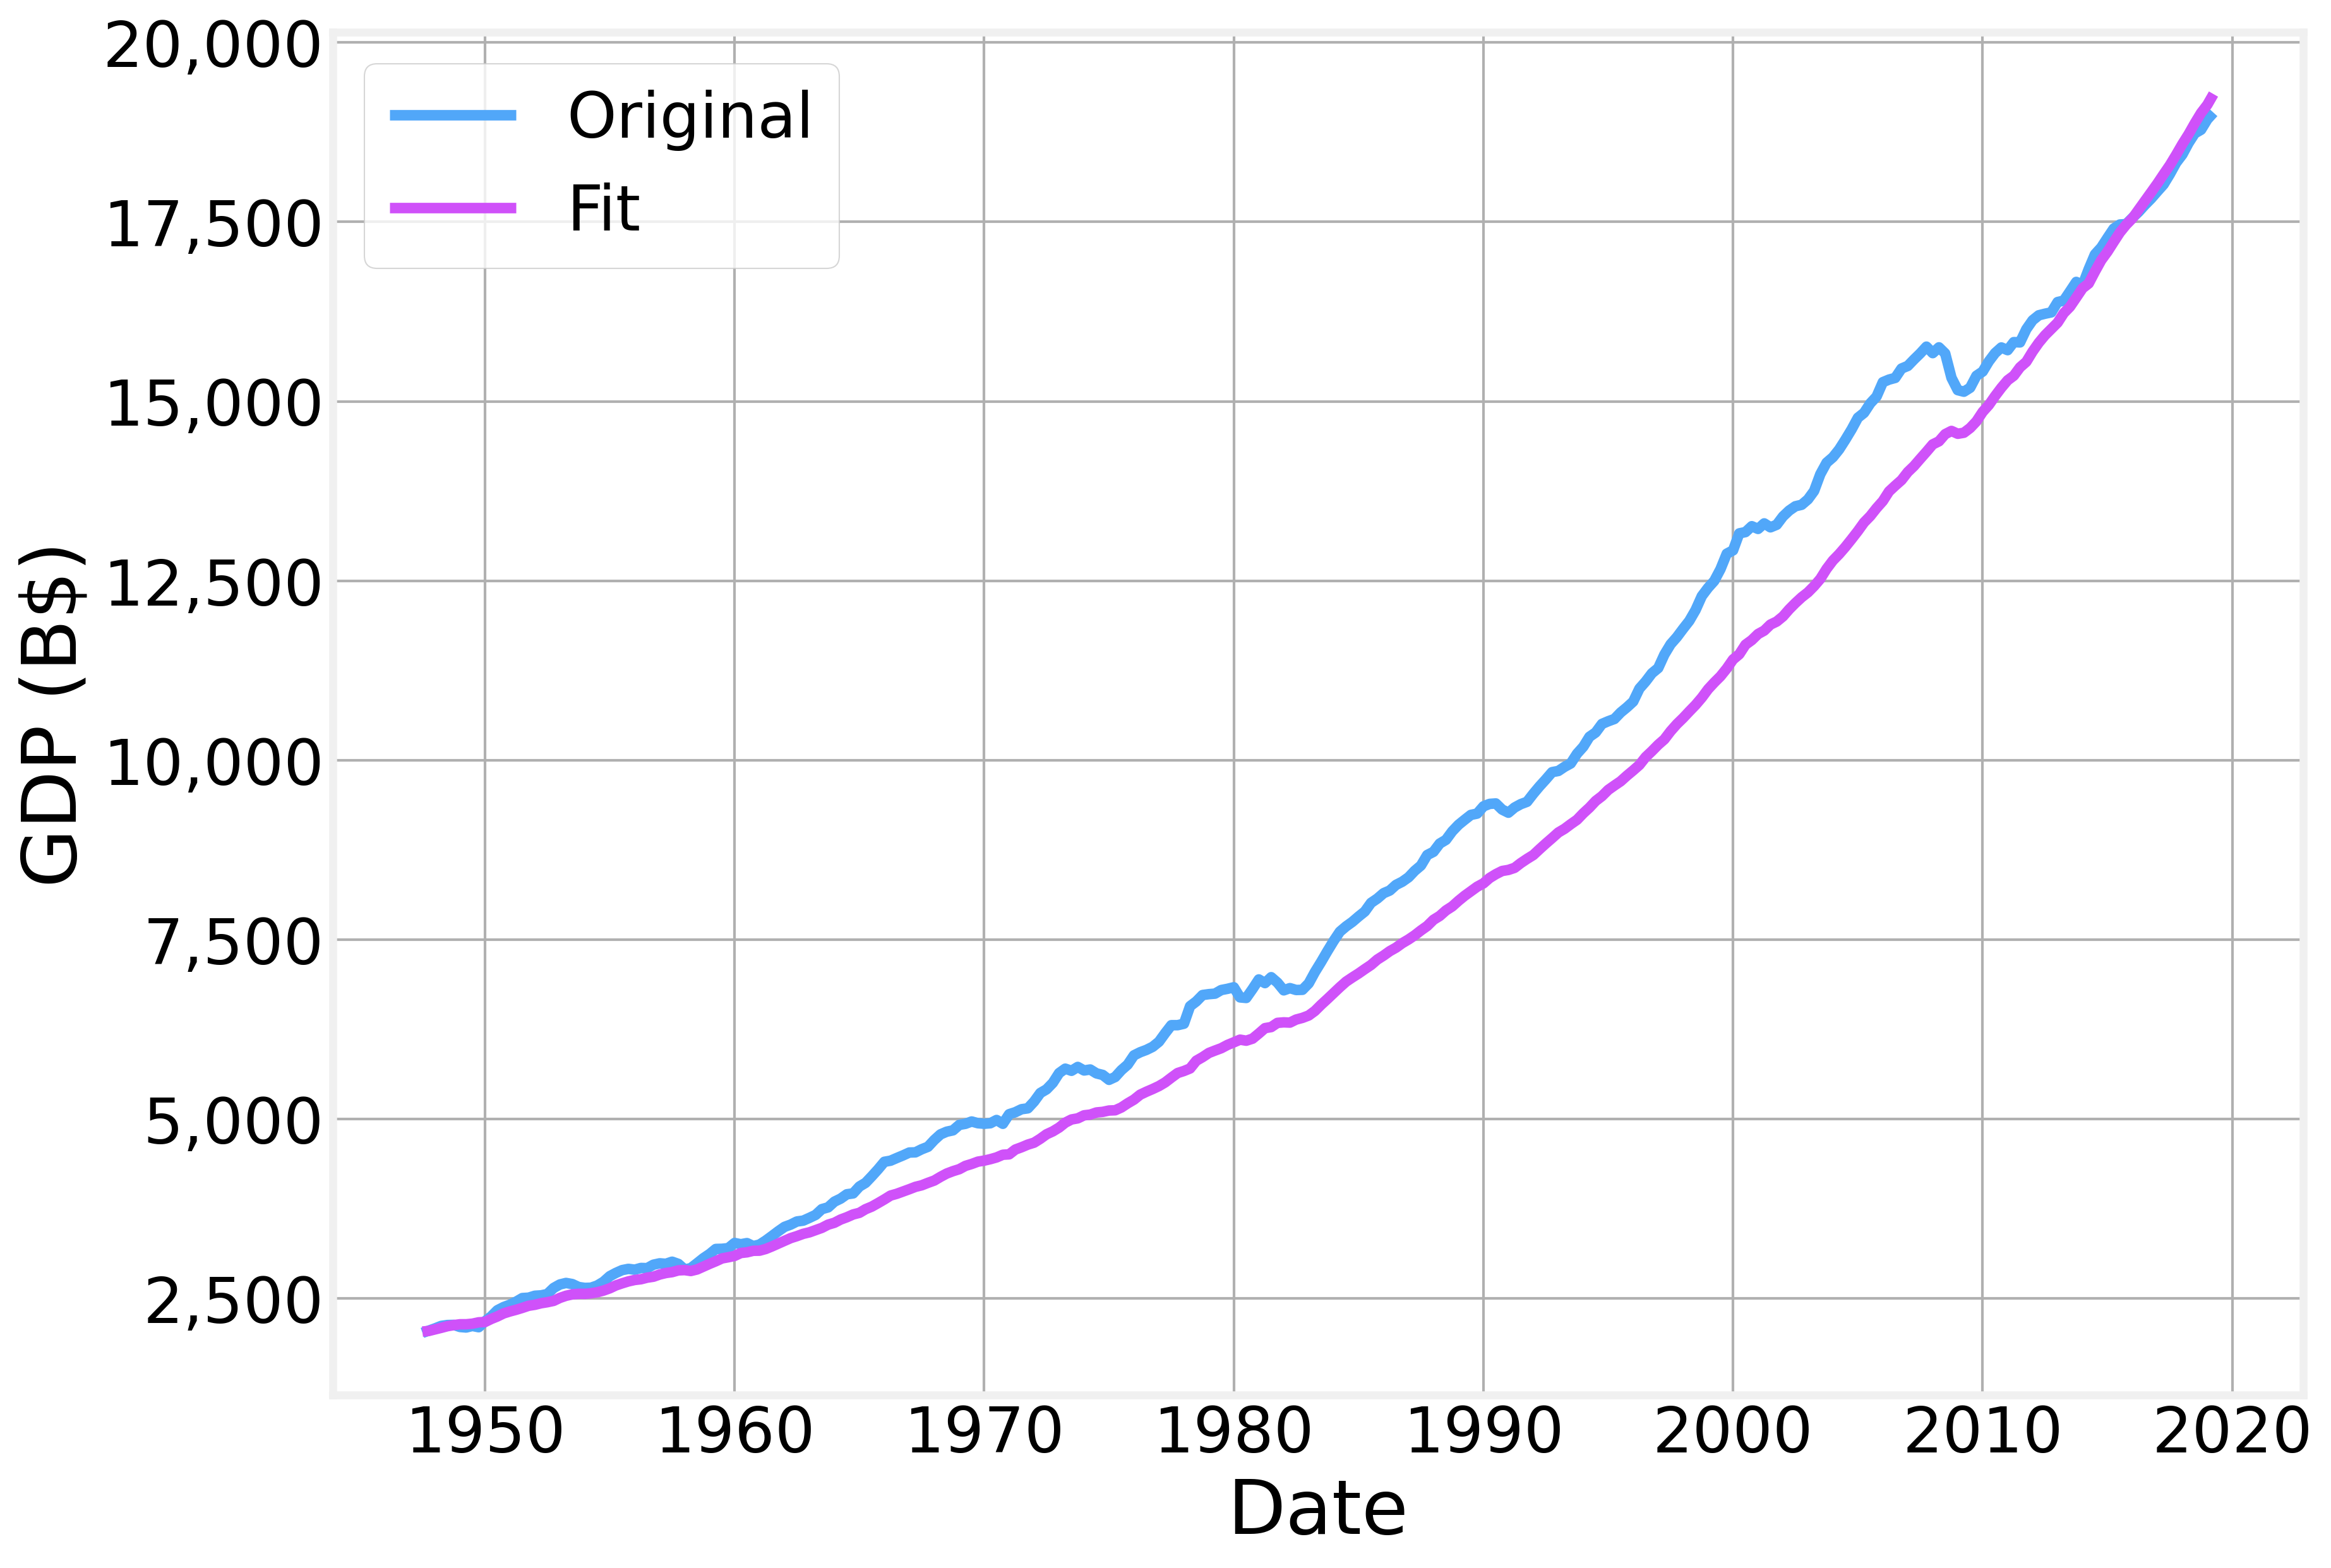

In [17]:
plt.plot(series.index[2:], series.values[2:], )
plt.plot(series.index[2:], (1+y_pred).cumprod()*series.values[0])
plt.xlabel('Date')
plt.ylabel('GDP (B$)')
plt.legend(['Original', 'Fit'])
plt.gca().get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')));

We are able to capture the overall trend, but we are still missing plenty of __important__ details

## Now without looking into the future

One of the problems with our approach is that we are using the entire time series to train our model, when we should be doing a train/test split

In [18]:
n_points = len(series)
train_points = int(2/3*n_points)+1

X_train = X[:train_points]
y_train = y[:train_points]
X_test = X[train_points:]
y_test = y[train_points:]

Now if we train on the training dataset and predict on the testing dataset

In [19]:
lm = LinearRegression()
lm.fit(X_train, y_train)

y_train_pred = lm.predict(X_train)
y_test_pred = lm.predict(X_test)

Now we can compare the fit values with the original QoQ data

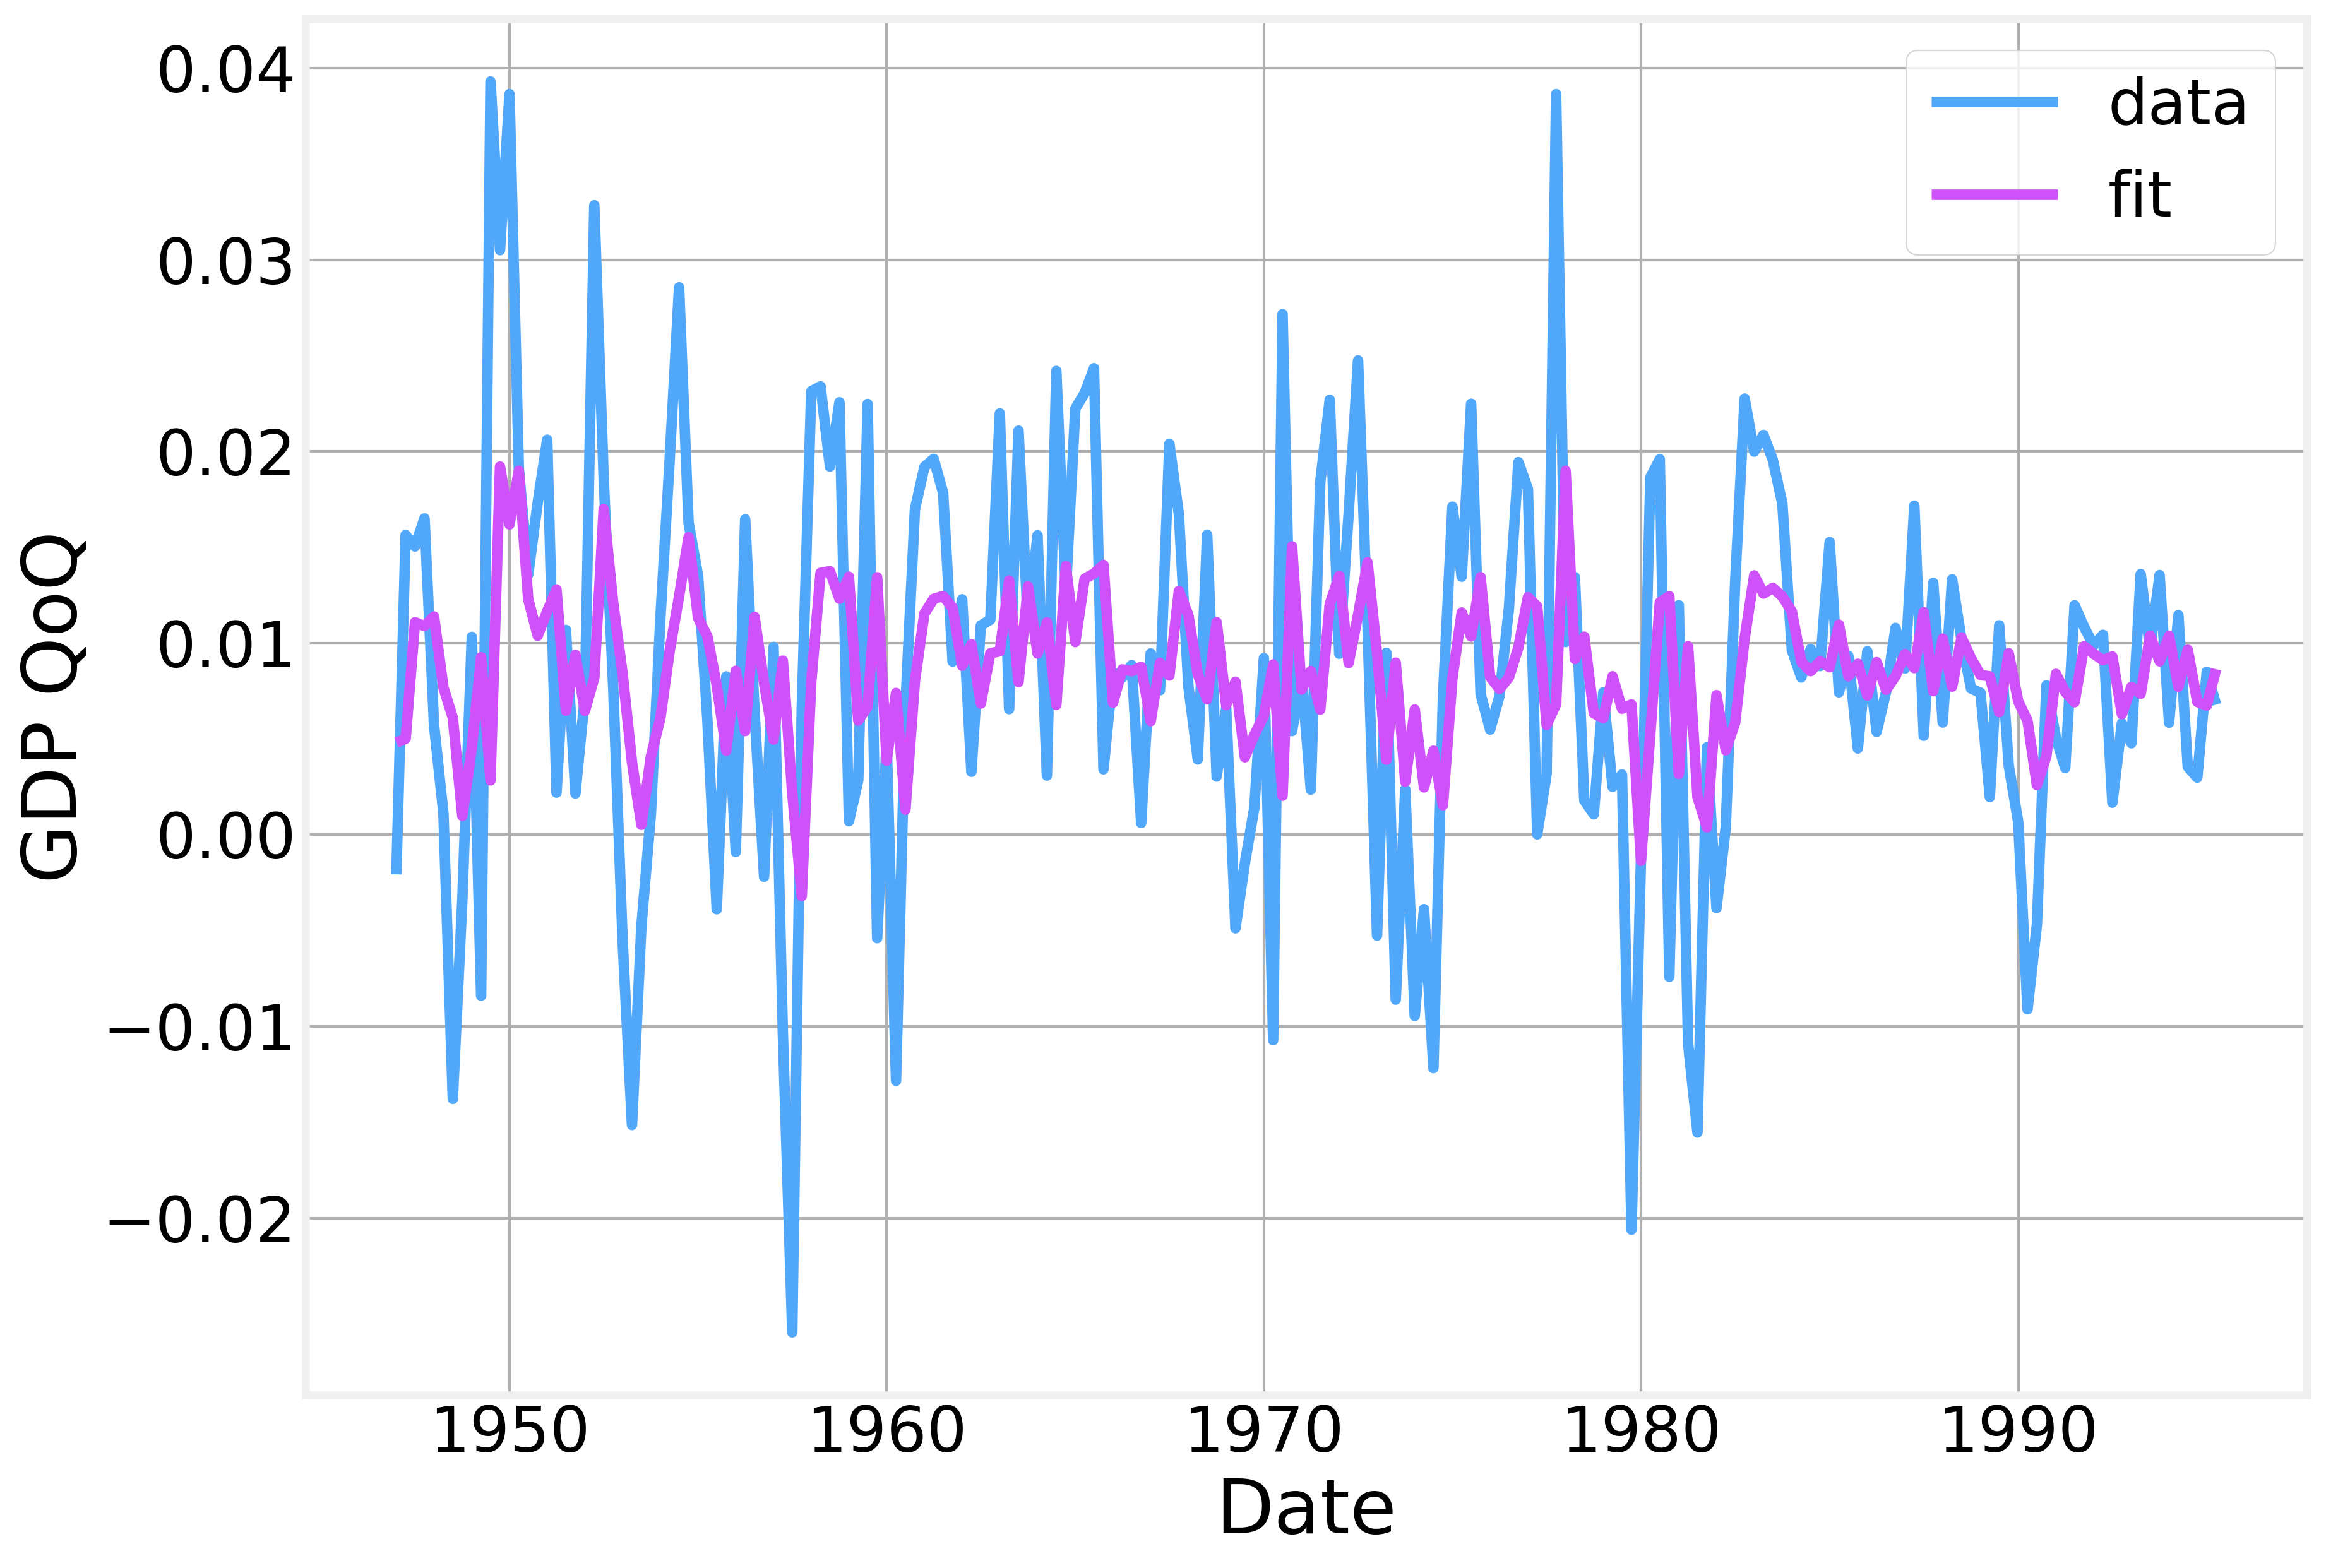

In [20]:
plt.plot(series.index[:train_points], y_train, label='data')
plt.plot(series.index[:train_points], y_train_pred, label='fit')
plt.xlabel('Date')
plt.ylabel('GDP QoQ')
plt.legend()

Now we compare the original train and testing datasets, plus the results of the fit for both cases

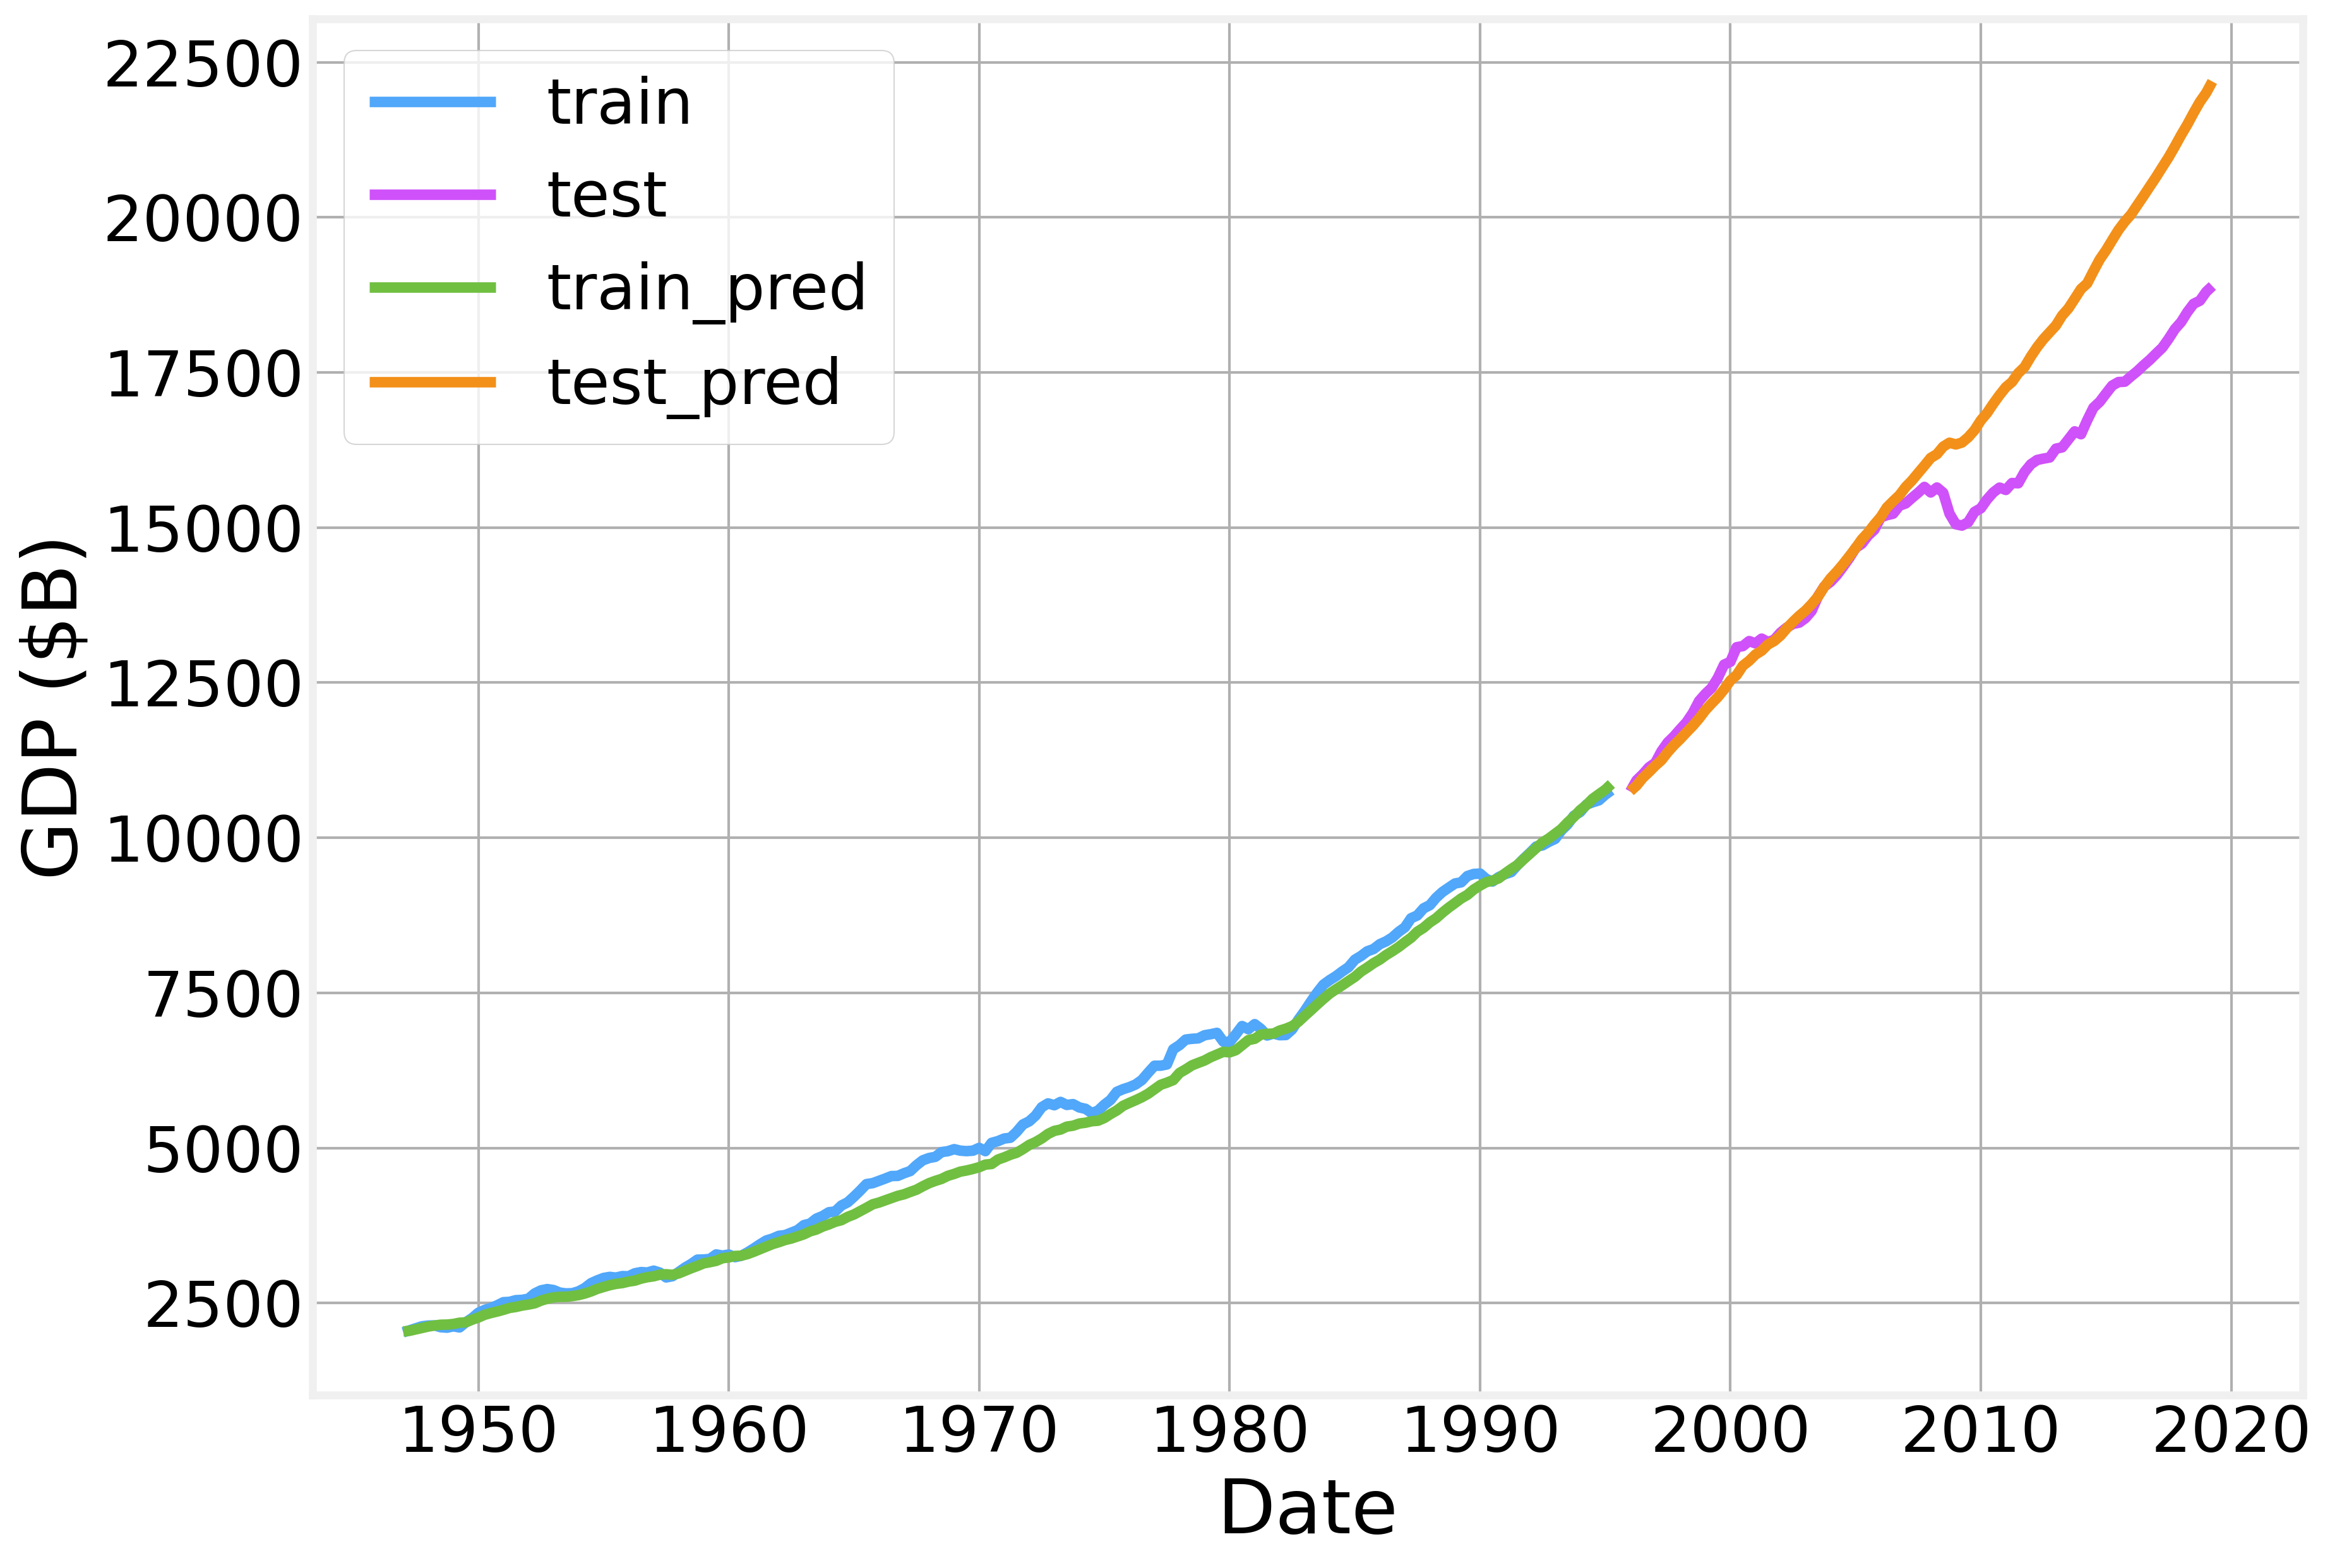

In [21]:
plt.plot(series.index[:train_points], (1+y_train).cumprod()*series.values[0], label='train')
plt.plot(series.index[train_points+2:], (1+y_test).cumprod()*series.values[train_points], label='test')
plt.plot(series.index[:train_points], (1+y_train_pred).cumprod()*series.values[0], label='train_pred')
plt.plot(series.index[train_points+2:], (1+y_test_pred).cumprod()*series.values[train_points], label='test_pred')
plt.xlabel('Date')
plt.ylabel('GDP ($B)')
plt.legend()

# ML ARIMA model

Utility function to generate the rolling window view of a vector

In [22]:
def rolling(x, order):
    npoints = x.shape[0]
    running = []
    
    for i in range(npoints-order):
        running.append(x[i:i+order])
        
    return np.array(running)

The build features function generates the AR and MA features and returns them in a table form

In [23]:
def build_features(x, p, q):                    
    AR_features = None
    MA_features = None

    # Determine the features and the epsilon terms for the MA process
    # We fit a simple linear regressoin
    lm = LinearRegression(fit_intercept=True)
    X = rolling(np.r_[np.zeros(p), x], p)
    lm.fit(X, x)
    
    # And the MA features are just the residuals
    residuals = lm.predict(X)-x
    residuals[0] = 0

    # prepend with zeros as there are no residuals_t-k in the first X_t
    MA_features = rolling(np.r_[np.zeros(q), residuals], q)

    # For the AR features, we just have to use the original values
    # prepend with zeros as there are no X_t-k in the first X_t
    AR_features = rolling(np.r_[np.zeros(p), x], p)

    n = min(len(AR_features), len(MA_features)) 
    AR_features = AR_features[:n]
    MA_features = MA_features[:n]
    features = np.hstack((AR_features, MA_features))
    
    # We return both the feature matrix and the truncated y values
    return features, x[:n]

Which we now apply to our training dataset, with p=q=2

In [24]:
features, y = build_features(y_train.flatten(), 2, 2)

The first 2 columns correspond to the AR features and the last 2 columns to the MA features

In [25]:
features[:10]

array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        , -0.00206496,  0.        ,  0.        ],
       [-0.00206496,  0.01564208,  0.        , -0.01108707],
       [ 0.01564208,  0.01504256, -0.01108707, -0.00517957],
       [ 0.01504256,  0.01650658, -0.00517957, -0.00518136],
       [ 0.01650658,  0.00572897, -0.00518136,  0.00599519],
       [ 0.00572897,  0.00111742,  0.00599519,  0.00739527],
       [ 0.00111742, -0.01377951,  0.00739527,  0.01985639],
       [-0.01377951, -0.00341097,  0.01985639,  0.00443119],
       [-0.00341097,  0.01032415,  0.00443119, -0.00747007]])

In [26]:
arima = LinearRegression(fit_intercept=True)
arima.fit(features, y)

LinearRegression()

In [27]:
y_ = arima.predict(features)

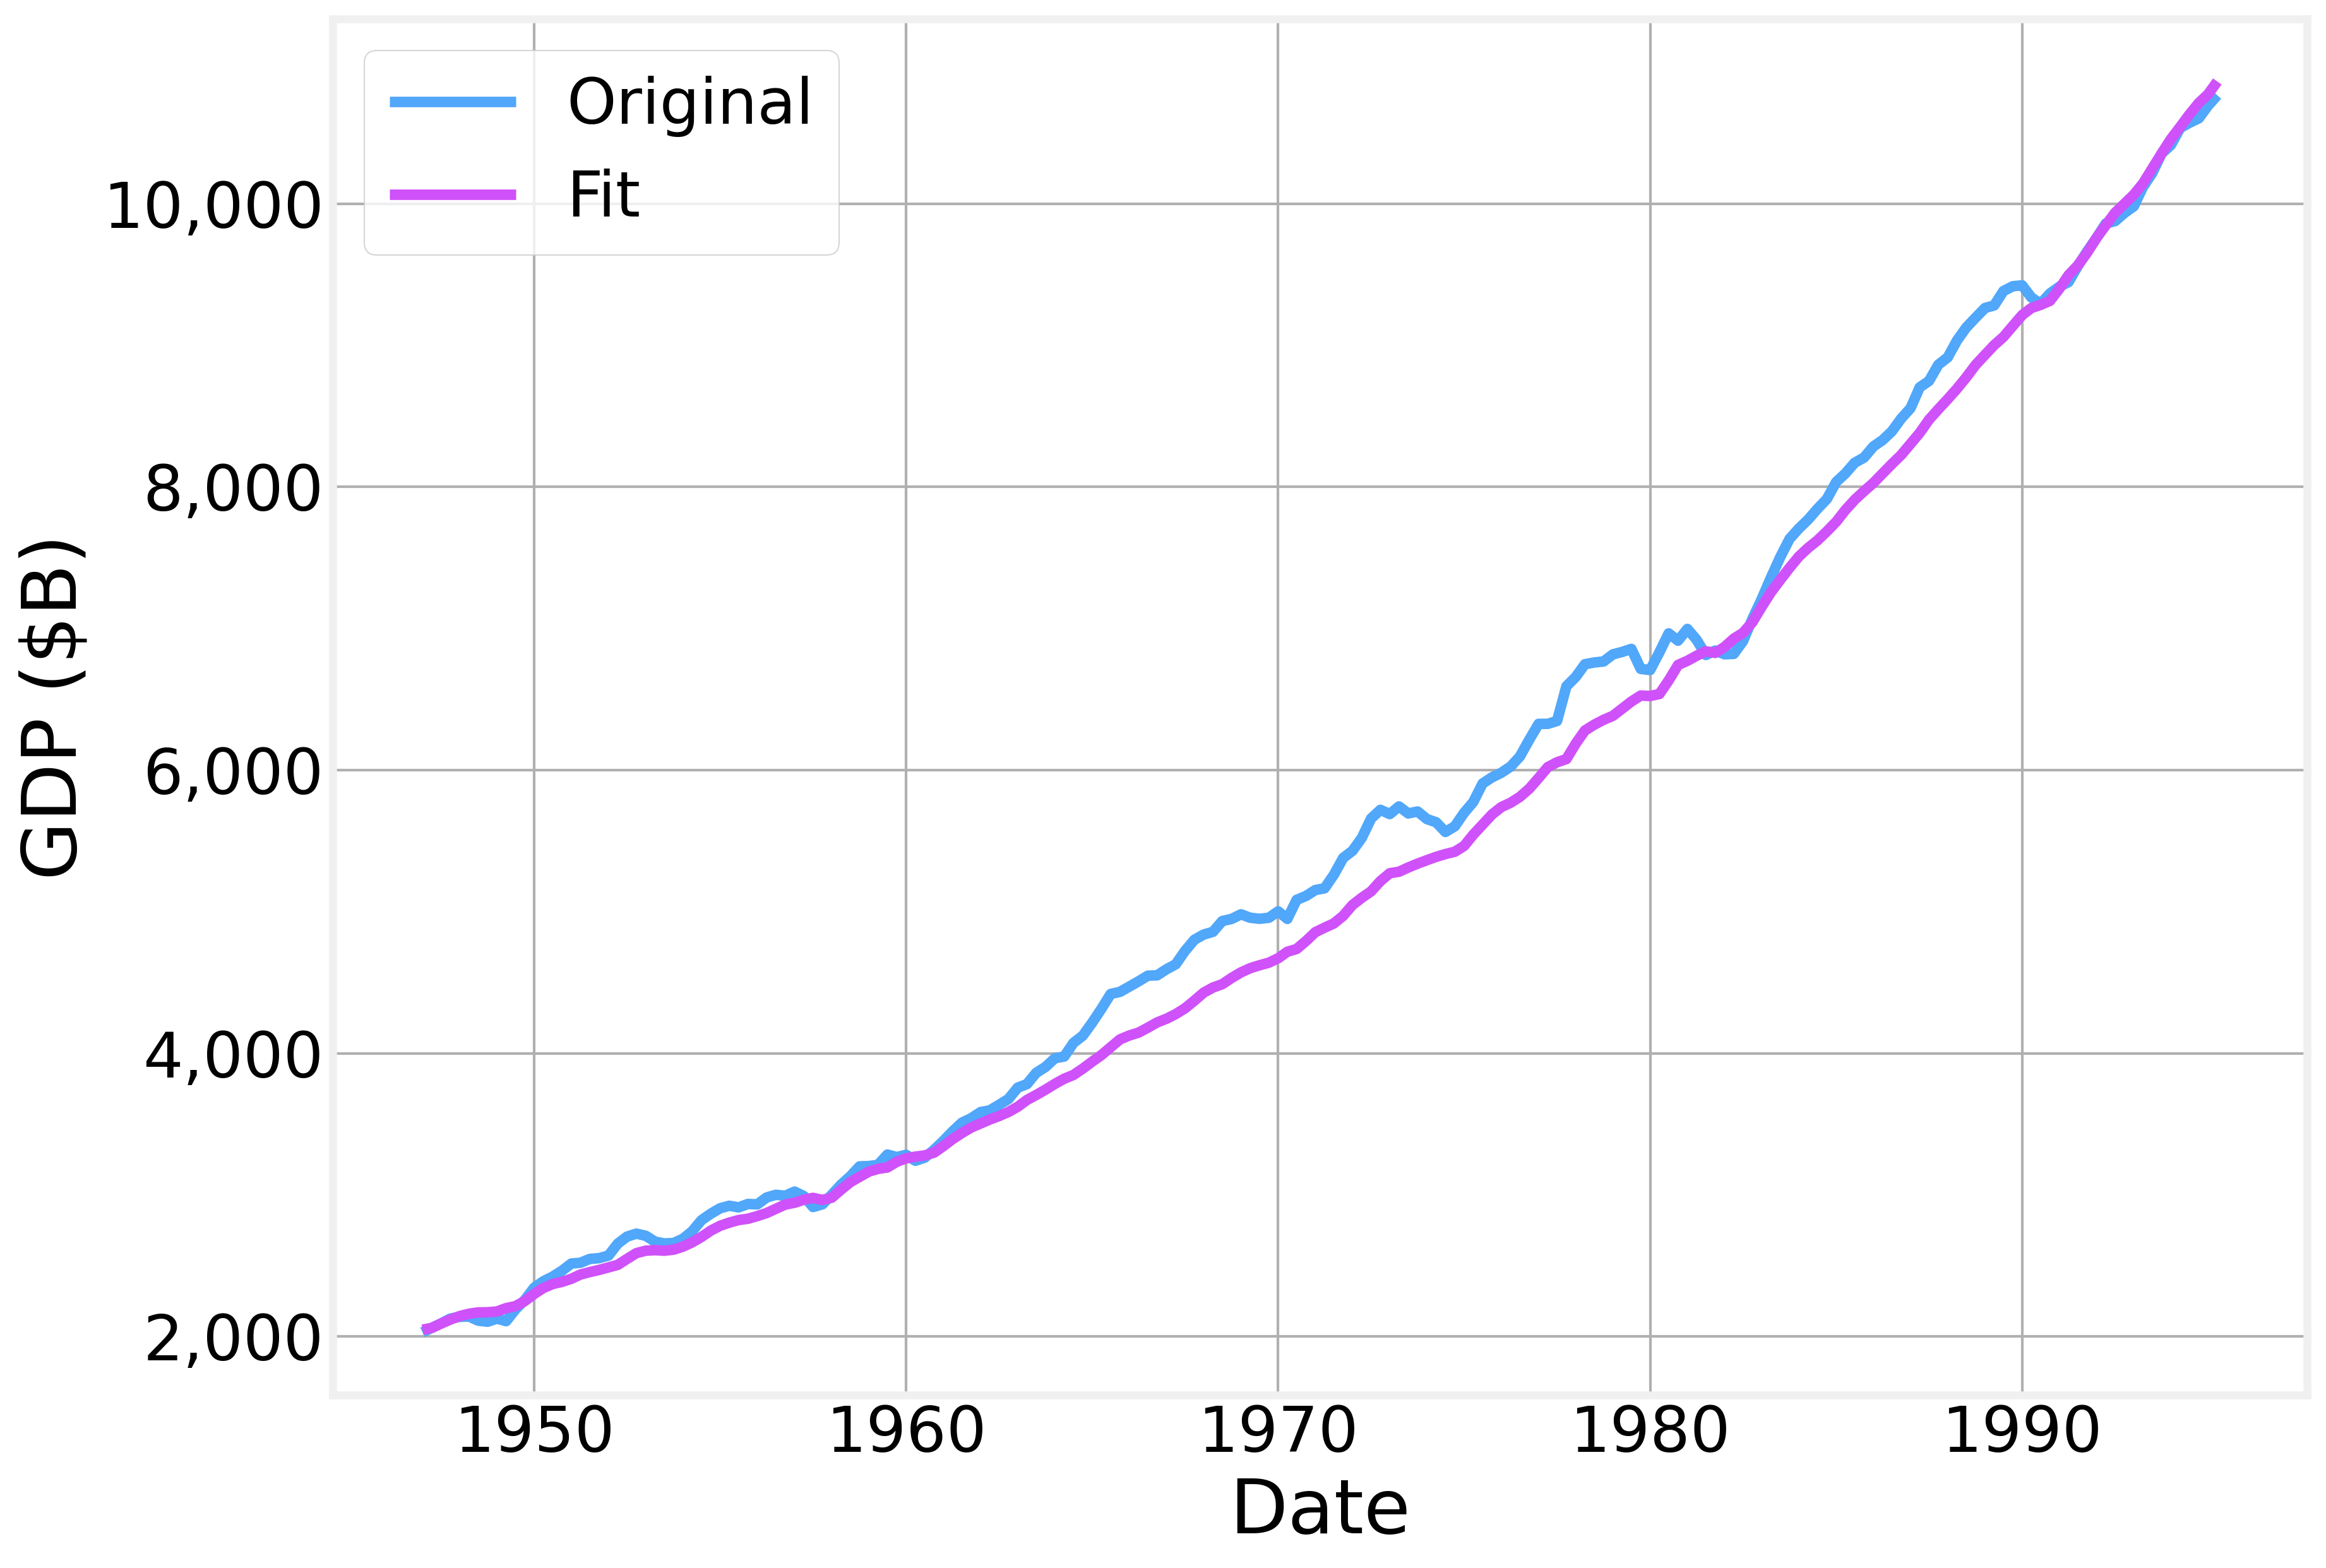

In [28]:
plt.plot(series.index[:train_points], (1+y_train).cumprod()*series.values[0], label='Original')
plt.plot(series.index[:train_points], (1+y_).cumprod()*series.values[0], label='Fit')
plt.xlabel('Date')
plt.ylabel('GDP ($B)')
plt.legend()
plt.gca().get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')));

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>